# QA0 FENIE

# Importar librerias

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import seaborn as sns
from hocelot.dlutils import get_col_feats,open
from datetime import datetime
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 400)
pd.set_option('max_colwidth',400)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from hocelot.dlmetadata.hocelot_types import HOCELOT_DTYPES, HOCELOT_FTYPES
from hocelot.dlmetadata.log_transformable_features import LOG_TRANSFORMABLE_1, LOG_TRANSFORMABLE_2
from hocelot.rdt.models import RDTransformer
import joblib
import bisect
import os
import pickle
import joblib
import re
import string
import subprocess
import random
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import lightgbm
from xgboost import XGBClassifier
from multiprocessing import cpu_count
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve
from hocelot.dlutils import get_col_feats, read_raw_data
from hocelot.dlutils import open as open_dlutils # open for saving PKL
#from hocelot.dlutils.miscellaneous import RANDOM_SEED, hocelot_colors
from hocelot.rdt import RDTransformer
from hocelot.dlmodels import XGBClassifierSelector
from hocelot.dlplots import ModelResultsGrapher, ModelExplainabilityGrapher, DefaultGrapher
#from hocelot.dlplots.classification.general_plots import plot_target_stability
from hocelot.dlmetadata import HOCELOT_DTYPES, HOCELOT_FTYPES, LOG_TRANSFORMABLE_1
from hocelot.dlutils.raw_data_reader import read_raw_data
from hocelot.dlutils import open
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 100)
HOCELOT_YELLOW = '#FDD226'
HOCELOT_BLACK = '#000000'
HOCELOT_RED = '#FF5753'
HOCELOT_BLUE = '#2B3252'
HOCELOT_WHITE = '#FFFFFF'
%matplotlib inline
warnings.filterwarnings('ignore')

# CARGAR FICHEROS

In [4]:
file_new ='gs://bucket_nb/input/XXXXX-fenie/Original/Dataset_Fenie_Hocelot_Jul21_Dic22_v2.txt'
data_new = pd.read_csv(file_new,sep = ';',index_col = False,encoding = 'latin-1')
print(data_new.shape)
data_new.head()

(6582219, 26)


,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Fecha Alta,Fecha Baja,Otras variables de interés,ID Factura,Fecha de emisión,Fecha de vencimiento de factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Fecha recuperación,Estado civil,Bureau de crédito,Score usado actualmente
0,Aarón Tortosa Moscardó,nan,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,18/08/2020,NaN,nan,2022010304356.0000,03/01/2022,13/01/2022,"61,89",no,NaN,NaN,NaN,nan,nan,Medio
1,Abdelhadi Driouich,nan,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",4610,driwchabdelahdig@gmail.com,34631070554.0000,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,22/07/2021,NaN,nan,2022010301105.0000,03/01/2022,13/01/2022,"124,94",no,NaN,NaN,NaN,nan,nan,Medio
2,Abdelkader Jabbour Koutaibi,nan,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",3360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,30/07/2021,NaN,nan,2022010300951.0000,03/01/2022,13/01/2022,"21,46",no,NaN,NaN,NaN,nan,nan,Bajo
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079.0000,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,09/11/2019,02/11/2021,nan,2022010301004.0000,03/01/2022,13/01/2022,"20,35",no,NaN,NaN,NaN,nan,nan,Medio
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243.0000,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,01/12/2020,20/10/2021,nan,2022010304946.0000,03/01/2022,13/01/2022,132,no,NaN,NaN,NaN,nan,nan,Medio Bajo


Observamos que el dataset está a nivel factura. 

# Transformación de formatos

In [5]:
data_new.dtypes

Nombre y apellidos                  object
Fecha de nacimiento                float64
NIF/DNI                             object
Dirección completa                  object
Código postal                       object
Email                               object
Teléfono                            object
ID Cliente                          object
Tipo de producto                    object
Canal Alta                          object
CUPS                                object
Tarifa                              object
Fecha Alta                          object
Fecha Baja                          object
Otras variables de interés         float64
ID Factura                         float64
Fecha de emisión                    object
Fecha de vencimiento de factura     object
Importe Factura                     object
Impago (si/no)                      object
Importe impagado                    object
Importe recuperado                  object
Fecha recuperación                  object
Estado civi

In [6]:
lista_importes=['Importe Factura','Importe impagado','Importe recuperado']
for col in lista_importes:
    data_new[col]=pd.to_numeric(data_new[col].dropna().astype(str).str.replace(',','.'))

In [7]:
for col in lista_importes: 
    data_new[col]=round(data_new[col],2)

In [8]:
data_new['Fecha de nacimiento'].isnull().sum()

6582219

comprobamos que la var. fecha_nacimiento no está informada en ningún caso (descartada)

In [9]:
lista_fechas=['Fecha Alta','Fecha Baja','Fecha de emisión','Fecha de vencimiento de factura']
for col in lista_fechas:
    data_new[col]= pd.to_datetime(data_new[col], format="%d/%m/%Y", errors="coerce").astype(str).str.slice(0,10)

In [10]:
# Pasamos de formato NaT para los nulos a formato np.nan
data_new['Fecha Baja_2']=np.where(data_new['Fecha Baja']=='NaT', np.nan,data_new['Fecha Baja'])
data_new['Fecha Alta_2']=np.where(data_new['Fecha Alta']=='NaT', np.nan,data_new['Fecha Alta'])
data_new['Fecha de emisión_2']=np.where(data_new['Fecha de emisión']=='NaT', np.nan,data_new['Fecha de emisión'])
data_new['Fecha de vencimiento de factura_2']=np.where(data_new['Fecha de vencimiento de factura']=='NaT', np.nan,data_new['Fecha de vencimiento de factura'])

In [11]:
# Vemos el numero de nulos para cada variable fecha
print(data_new['Fecha Baja_2'].isnull().sum())
print(data_new['Fecha Alta_2'].isnull().sum())
print(data_new['Fecha de emisión_2'].isnull().sum())
print(data_new['Fecha de vencimiento de factura_2'].isnull().sum())

5225618
362060
358695
358695


In [12]:
#formato correcto de fechas, de variables numéricas
import xlrd
from dateutil.parser import parse
def validate_date(date_text):
    if date_text=='NaT' or date_text!=date_text:
        return ''
    try:
        parse(str(date_text)[0:10],dayfirst=False)
        datetime.strptime(str(date_text)[0:10], '%d/%m/%Y')
        return ''
    except ValueError:
        try:
            date_text = xlrd.xldate.xldate_as_datetime(date_text, 0)
        except:
            print(date_text)

In [13]:
#Aplicamos la funcion definida anteriormente
data_new.loc[(data_new['Fecha recuperación'].astype(str)!=data_new['Fecha recuperación'])&(data_new['Fecha recuperación'].notna()),'Fecha recuperación'] = \
data_new.loc[(data_new['Fecha recuperación'].astype(str)!=data_new['Fecha recuperación'])&(data_new['Fecha recuperación'].notna()),'Fecha recuperación'].apply(
            lambda x: (xlrd.xldate.xldate_as_datetime(x, 0)).strftime("%Y/%m/%d"))
data_new.loc[data_new['Fecha recuperación'].astype(str).apply(lambda x: x.isnumeric()),'Fecha recuperación'] = \
data_new.loc[data_new['Fecha recuperación'].astype(str).apply(lambda x: x.isnumeric()),'Fecha recuperación'].apply(
            lambda x: (xlrd.xldate.xldate_as_datetime(pd.to_numeric(x), 0)).strftime("%Y/%m/%d"))

In [15]:
data_new['Fecha recuperación'] = pd.to_datetime(data_new['Fecha recuperación'], format="%d/%m/%Y", errors="coerce"
            ).fillna(pd.to_datetime(data_new['Fecha recuperación'], format="%Y/%m/%d", errors="coerce")).astype(str).str.slice(0,10)
data_new['Fecha recuperación_2']=np.where(data_new['Fecha recuperación']=='NaT', np.nan,data_new['Fecha recuperación'])

In [16]:
#Elimino columnas que han sido cambiadas de formato
data_new.drop(columns=['Fecha de emisión','Fecha Alta', 'Fecha Baja','Fecha de vencimiento de factura','Fecha recuperación'],inplace=True)

#### Formato TELEFONO

In [20]:
data_new['Teléfono ']=data_new['Teléfono '].astype(str).str.split('.').apply(lambda x: x[0])
data_new['Teléfono '] = np.where(data_new['Teléfono ']=='nan', np.nan, data_new['Teléfono '])

In [17]:
#data_new.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_new_formatos.csv',sep=';', index=False)
data_new=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_new_formatos.csv',sep=';', index_col=False)

# PASO 1: REVISAR CAMPOS

Para saber los puntos a revisar en el QA0 consultar: https://docs.google.com/document/d/108YiCsNO4zly_FB-oMvjOfWm8IEYm1VQFlPQEIkTLxs/edit

In [22]:
data_new.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
0,Aarón Tortosa Moscardó,nan,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,nan,2022010304356.0000,61.8900,no,nan,nan,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN
1,Abdelhadi Driouich,nan,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",4610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,nan,2022010301105.0000,124.9400,no,nan,nan,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN
2,Abdelkader Jabbour Koutaibi,nan,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",3360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,nan,2022010300951.0000,21.4600,no,nan,nan,nan,nan,Bajo,NaN,2021-07-30,2022-01-03,2022-01-13,NaN
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2022010301004.0000,20.3500,no,nan,nan,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304946.0000,132.0000,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN


tenemos todos los campos completos

### DIVIDO GAS Y ELECTRICIDAD

Dividimos entre gas y electricidad porque en principio se iba a hacer un modelo solo para electricidad. Mas adelante se nos pidió hacer tambien uno sobre gas.

In [18]:
data_new_gas = data_new[data_new['Tipo de producto']=='Gas']
data_new = data_new[data_new['Tipo de producto']=='Electricidad']

Sacamos el importe de la factura para los últimos 4 meses para incluirlo en la calculadora. (Lo hacemos en esta parte porque luego eliminaremos estos últimos 4 meses)

In [19]:
data_new[data_new['Fecha de vencimiento de factura_2']>'2022-08-30']['Importe Factura'].mean()

75.91220126926424

In [20]:
print(data_new.shape)
data_new.head()

(5899138, 26)


,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
0,Aarón Tortosa Moscardó,nan,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,nan,2022010304356.0000,61.8900,no,nan,nan,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN
1,Abdelhadi Driouich,nan,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",4610,driwchabdelahdig@gmail.com,34631070554.0000,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,nan,2022010301105.0000,124.9400,no,nan,nan,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN
2,Abdelkader Jabbour Koutaibi,nan,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",3360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,nan,2022010300951.0000,21.4600,no,nan,nan,nan,nan,Bajo,NaN,2021-07-30,2022-01-03,2022-01-13,NaN
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079.0000,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2022010301004.0000,20.3500,no,nan,nan,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243.0000,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304946.0000,132.0000,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN


# Paso 2: Missing values y valores incorrectos

In [21]:
data_new.isnull().sum()

Nombre y apellidos                         0
Fecha de nacimiento                  5899138
NIF/DNI                                    0
Dirección completa                         0
Código postal                              0
Email                                 701440
Teléfono                             2450153
ID Cliente                                 0
Tipo de producto                           0
Canal Alta                                 0
CUPS                                       0
Tarifa                                     0
Otras variables de interés           5899138
ID Factura                                 0
Importe Factura                            0
Impago (si/no)                             0
Importe impagado                     5735567
Importe recuperado                   5735567
Estado civil                         5899138
Bureau de crédito                    5899138
Score usado actualmente              1214715
Fecha Baja_2                         4611167
Fecha Alta

Proveniente de la librería hocelot.dutils tenemos el comando get_col_feats que nos proporciona informacion sobre los missng values y de los valores únicos por variable

In [22]:
get_col_feats(data_new)

100%|██████████| 26/26 [00:26<00:00,  1.02s/it]


,dtype,sample,n_missing,perc_missing,n_unique
Nombre y apellidos,object,Aarón Tortosa Moscardó,0,0.0000,315002
Fecha de nacimiento,float64,NaN,5899138,100.0000,1
NIF/DNI,object,73101526M,0,0.0000,318794
Dirección completa,object,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",0,0.0000,451474
Código postal,object,46830,0,0.0000,16712
Email,object,aarontortosa1997@gmail.com,701440,11.8906,221010
Teléfono,object,34670261219.0000,2450153,41.5341,335119
ID Cliente,object,73101526M,0,0.0000,318753
Tipo de producto,object,Electricidad,0,0.0000,1
Canal Alta,object,Agente,0,0.0000,1


Borramos todas las variables que tienen 100% desinformados y las que tienen un unico valor

In [24]:
data_new.drop(columns=['Fecha de nacimiento','Otras variables de interés','Estado civil','Bureau de crédito'],inplace=True)

In [25]:
data_new.shape

(5899138, 22)

Podriamos haber quitado tambien canal de alta y tipo de producto

## Punto 2b: Valores incorrectos

Buscamos longitudes anormalmente cortas de algunas variables que nos indicarían que se está informando mal

In [27]:
for col in ['Código postal', 'Teléfono ', 'NIF/DNI', 'CUPS']:
    print(col)
    print(data_new[data_new[col].astype(str).apply(len)<5].shape[0])
    print(100*data_new[data_new[col].astype(str).apply(len)<5].shape[0]/data_new.shape[0])
    print()

Código postal
0
0.0

Teléfono 
2450239
41.53554298950118

NIF/DNI
14
0.00023732280885783652

CUPS
0
0.0



In [28]:
# Rellenamos con 0 a la izquierda para que el CP siempre tenga 5 dígitas
data_new['Código postal']=data_new['Código postal'].astype(str).str.rjust(5,'0')

In [29]:
for col in ['Código postal', 'Teléfono ', 'NIF/DNI', 'CUPS']:
    print(col)
    print(data_new[data_new[col].astype(str).apply(len)<5].shape[0])
    print(100*data_new[data_new[col].astype(str).apply(len)<5].shape[0]/data_new.shape[0])
    print()

Código postal
0
0.0

Teléfono 
2450239
41.53554298950118

NIF/DNI
14
0.00023732280885783652

CUPS
0
0.0



In [30]:
data_new[(data_new['Teléfono '].astype(str).apply(len)<5)&(data_new['Teléfono '].notnull())].head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
1434193,Bárbara Gelene Sass-Hildenbrand,X2554066P,"França 0044, 07159 S'Arraco (BALEARS)",07159,samueldiaz@grupoac.es,#N/D,X2554066P,Electricidad,Agente,ES0031500190332001XQ,2.0TD,2022070426927.0000,52.4400,no,nan,nan,#N/D,NaN,2015-05-04,2022-07-04,2022-07-11,NaN
1436697,David Andrés Calvo,12745576B,"Medio 0012, Bjo, 34116 Bustillo de la Vega (PALENCIA)",34134,NaN,#N/D,12745576B,Electricidad,Agente,ES0027700178804001RE0F,2.0TD,2022070435399.0000,9.9800,no,nan,nan,#N/D,NaN,2014-03-08,2022-07-04,2022-07-11,NaN


Vemos que para tlefono e email tenemos valores nulos que no vienen informados como nulos y los transformaos en nulos

In [31]:
data_new[(data_new['Teléfono ']=='#N/D')].shape

(86, 22)

In [33]:
data_new[(data_new['Email ']=='#N/D')].shape

(1224, 22)

In [34]:
data_new['Teléfono ']=np.where(data_new['Teléfono ']=='#N/D', np.nan,data_new['Teléfono '])

In [35]:
data_new['Email ']=np.where(data_new['Email ']=='#N/D', np.nan,data_new['Email '])

Buscamos los carácteres especiales que no deberian aparecer en algunas variables de tipo string

In [36]:
special_characters = "!\"#$%&()*+,./:;<=>?@[\]^_`{|}~"
s=data_new['Nombre y apellidos ']
Nombres=s[s.apply(lambda x: sum([ch in str(x) for ch in special_characters ])>0)]
# Example: $tackoverflow
#if any(c in special_characters for c in s):
    #print("yes")
#else:
   # print("no")

In [37]:
Nombres

1975                               M. Dolores Monfor Olmos
1981                          MALLART JULIEN JEAN, MAURICE
7014                                   FRANCISCO ALVAREZ .
7744                                     Guzeliya ADEEVA .
10726                            KOENRAAD GERARD R. STUBBE
                                ...                       
6389783                    Francisco Martín Salcines, C.B.
6392020                               MARC HENRI A. LORENT
6393245                          MURIEL FERNAND O WANLIN .
6393386                           OSCAR TRIFON M. VANHOUDT
6394476    Valère Telesphore G.a.g Frennet Frennet FRENNET
Name: Nombre y apellidos , Length: 3447, dtype: object

Dentro de Nombres y Apellidos hemos sacado que hay un total de 3447 de registros que contienen carat.especiales. Los pasamos por alto aunque lo destacamos en el reporte (ppt QA0)

In [38]:
special_characters = "!\"$%&*+;<=>?@[\]^_{|}~"
s=data_new['Dirección completa ']
direcciones=s[s.apply(lambda x: sum([ch in str(x) for ch in special_characters ])>0)]
## Example: $tackoverflow
#if any(c in special_characters for c in s):
    #print("yes")
#else:
    #print("no")

In [39]:
direcciones

501          CL UR.l INDUSTRIAL 134, VlV, \rvEB 001 001, 29530 ALAMEDA (MALAGA)
1512                  REAL S/N, Bloque POLIG.25, PARC.1,, 4500 FI?ANA (ALMERIA)
1527                                     RUA NOVA 36, 3? B, 27600 SARRIA (LUGO)
2287                             BONICO *, FINCA /, 07640 SES SALINES (BALEARS)
3226                                   BOLIVIA 00025 \, 36204 Vigo (PONTEVEDRA)
                                           ...                                 
6387949             HAZA DE LOS CALZONES 00100 \, 13230 Membrilla (CIUDAD REAL)
6387950             HAZA DE LOS CALZONES 00100 \, 13230 Membrilla (CIUDAD REAL)
6388734               VIALLAN 9, Bloque BLOQUE 3, 1? C, 39525 ORE?A (CANTABRIA)
6393610    Cigarra Baja 32, 9 Pol 6 Parc 130, 14720 Almod?var del R?o (CORDOBA)
6394226                    Avda. San Diego 21 ESC 1 !º B, 28053 MADRID (MADRID)
Name: Dirección completa , Length: 4084, dtype: object

###### 4084 direcciones que vienen informada con caract. raros

In [40]:
data_new['Teléfono '].astype(str).apply(len).value_counts()

13    2513638
3     2450239
11     928213
14       3853
12       1942
15        805
10        288
9         129
16         31
Name: Teléfono , dtype: int64

In [41]:
data_new[data_new['Teléfono '].astype(str).apply(len)==9]

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
1429051,JOSE MARIA FERRAS BORRAS,18579204B,"HORNO 5, 44623 CRETAS (TERUEL)",44623,akelarre1000@gmail.com,669133473,18579204B,Electricidad,Agente,ES0031406026100001GM0F,2.0TD,2022070300883.0000,49.4600,no,nan,nan,Bajo,NaN,2022-05-18,2022-07-03,2022-07-10,NaN
1443089,Jacinta Iglesia Lorenzo,76099046G,"Real 0077, 2, A, 10810 Montehermoso (CACERES)",10810,loiggocanidajaso@gmail.com,376343206,76099046G,Electricidad,Agente,ES0021000002381849ZN,2.0TD,2022070431515.0000,43.1200,no,nan,nan,Bajo,NaN,2017-03-09,2022-07-04,2022-07-11,NaN
1477567,GUILLERMO FABRE ECHEVERRIA,53995680Y,"MAESTRO SERRANO 21, 3 I, 28400 LA ESTACION (COLLADO VILLALBA) (MADRID)",28400,johnnyochoa60@hotmail.com,680117439,53995680Y,Electricidad,Agente,ES0021000004191895YG,2.0TD,2022070508559.0000,172.3400,no,nan,nan,Medio,2022-11-25,2022-05-20,2022-07-05,2022-07-15,NaN
1479259,JAVIER GARCIA RODRICUEZ,45576969P,"ESCALERA PARCELA PLANTA 18 0946, 09462 MORADILLO DE ROA (BURGOS)",09462,catirodrin8@gmail.com,610023237,45576969P,Electricidad,Agente,ES0021000041747077RG,2.0TD,2022070524297.0000,25.8200,no,nan,nan,Bajo,NaN,2022-04-07,2022-07-05,2022-07-12,NaN
1490800,MARIA ISABEL FELIU AGUILELLA,73367056T,"POLIGONO 2 0169, 12200 ONDA (CASTELLO/CASTELLON)",12200,aguilellamonzonis@gmail.com,646183236,73367056T,Electricidad,Agente,ES0021000041409407QC,2.0TD,2022070532081.0000,9.9800,no,nan,nan,Bajo,NaN,2022-01-05,2022-07-05,2022-07-12,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045171,JOSE MARIA GATO LOPEZ,80070517L,"OCEANIA 10, 9, 1, A, 28922 ALCORCON (MADRID)",28922,josemariagato@hotmail.com,646740488,80070517L,Electricidad,Agente,ES0021000016783821NM,2.0TD,2022092707306.0000,39.4700,no,nan,nan,Medio,NaN,2020-10-03,2022-09-27,2022-10-06,NaN
6047880,MARIA ROSARIO NOGUEIRA COSTAS,36076614X,"PARROQUIA MOS 71, 36416 CASAL (TAMEIGA) (PONTEVEDRA)",36416,alperinfraestructuras@gmail.com,692128364,36076614X,Electricidad,Agente,ES0022000001329304GY1P,2.0TD,2022092711462.0000,12.0300,no,nan,nan,Bajo,NaN,2022-06-07,2022-09-27,2022-10-06,NaN
6363364,RICHARD LASCELLES DENNYS,Y9681551Z,"ISAAC ALBENIZ 8, Bloque 1, 2 A, 07669 CALONGE (BALEARS)",07669,richard.dennys@gmail.com,447487484,Y9681551Z,Electricidad,Agente,ES0031500525027009MJ0F,2.0TD,2022102605954.0000,49.2100,no,nan,nan,Medio Alto,NaN,2022-08-23,2022-10-26,2022-11-04,NaN
6378993,JOSE MARIA GATO LOPEZ,80070517L,"OCEANIA 10, 9, 1, A, 28922 ALCORCON (MADRID)",28922,josemariagato@hotmail.com,646740488,80070517L,Electricidad,Agente,ES0021000016783821NM,2.0TD,2022102802150.0000,46.7000,no,nan,nan,Medio,NaN,2020-10-03,2022-10-28,2022-11-07,NaN


NO detectamos ningún patrón raro en la variable Tlf

In [42]:
#data_new.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_new_formatos_electricidad.csv', sep=';', index=False)

## Quitamos los ultimos 4 meses
Los quitamos porque las facturas que aparezcan en esos 4 meses no tienen tiempo suficiente para poder observar si entran en mora

In [43]:
data_new['Fecha de vencimiento de factura_3']=data_new['Fecha de vencimiento de factura_2'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [44]:
data_new=data_new[data_new['Fecha de vencimiento de factura_3'] <= datetime.strptime('2022-08-30', '%Y-%m-%d')]

In [45]:
data_new.shape

(4597439, 23)

# Punto 3: Persona, contrato/s CUPS

In [95]:
data_new.head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN
1,Abdelhadi Driouich,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",04610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,2022010301105.0000,124.9400,no,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN


In [46]:
# Numero de facturas
data_new['ID Factura'].nunique()

4597439

In [49]:
# Numero de clientes
data_new['NIF/DNI'].nunique()

307826

In [48]:
# Numero de CUPS
data_new['CUPS'].nunique()

368185

Un DNI puede tener varios CUPS y un CUPS puede tener varios DNI asociados

In [50]:
df_DNI_CUPS = data_new.fillna(0).groupby('NIF/DNI',as_index = False)[['CUPS'
                                ]].agg([pd.Series.nunique,set])[['CUPS']]
df_DNI_CUPS[df_DNI_CUPS['CUPS']['nunique']>1]

CUPS  \
          nunique   
NIF/DNI             
00002909B       2   
00006712L       2   
00015887V       2   
00019788P       2   
00020407Y       3   
...           ...   
YA5868767       2   
YA8864111       2   
x1007765C       2   
x2466593G       2   
x3506482v       4   

                                                                                                             
                                                                                                        set  
NIF/DNI                                                                                                      
00002909B                                                      {ES0021000005169213VY, ES0021000004651381LL}  
00006712L                                                  {ES0026000000382372WJ0F, ES0026000000379597LK0F}  
00015887V                                                      {ES0021000000856841HL, ES0021000000856847LW}  
00019788P                                                  {ES0022000006128929GZ1P, ES0022000005247122YG1P}  
00020407Y                                {ES0021000005547156GJ, ES0021000005549383DD, ES0021000005549381DF}  
...                                                                                                     ...  
YA5868767                                                  {ES0031406011554005TZ0F, ES0031406013665018JH0F}  
YA8864111                                                  {ES0031500155731013AK0F, ES0031500137659002JF0F}  
x1007765C                                                  {ES0031406123745003FW0F, ES0031408142261001NM0F}  
x2466593G                                                  {ES0031500527994003KF0F, ES0031500292936021KR0F}  
x3506482v  {ES0031104110753001KL0F, ES0031104784917014RS0F, ES0031103430108001DE0F, ES0031104111189001AP0F}  

[48699 rows x 2 columns]

In [51]:
df_CUPS_DNI = data_new.fillna(0).groupby('CUPS',as_index = False)[['NIF/DNI'
                                ]].agg([pd.Series.nunique,set])[['NIF/DNI']]
df_CUPS_DNI[df_CUPS_DNI['NIF/DNI']['nunique']>1]

NIF/DNI                        
                       nunique                     set
CUPS                                                  
ES0021000000080404RQ         2  {12310345D, Y9361745T}
ES0021000000146543WF         2  {06525470W, 15240883W}
ES0021000000165330ZA         2  {16276540S, 50464710L}
ES0021000000169628VT0F       2  {16299847T, 01935058E}
ES0021000000178878MG         2  {07537721T, 74506833N}
...                        ...                     ...
ES0479000000001773ML         2  {17999062K, 18049213D}
ES0496000000000918VY1P       2  {X9329376R, 33850002M}
ES0570000009879241MD         2  {72819700K, 72692037P}
ES0572000000000057BH0F       2  {73554995Y, 73554953X}
ES0687000000000014MK         2  {76814399B, 54151617A}

[11886 rows x 2 columns]

In [53]:
# Un ejemplo
data_new[data_new['NIF/DNI']=='00002909B']

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de vencimiento de factura_3
289967,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2022012717145.0000,234.0000,no,nan,nan,Medio Bajo,NaN,2019-11-30,2022-01-27,2022-02-03,NaN,2022-02-03
652492,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336.0000,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2022022406372.0000,173.3900,no,nan,nan,Medio Bajo,NaN,2019-11-30,2022-02-24,2022-03-06,NaN,2022-03-06
1064050,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336.0000,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2021072809411.0000,66.6600,no,nan,nan,Medio Bajo,NaN,2019-11-30,2021-07-28,2021-08-07,NaN,2021-08-07
1396986,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336.0000,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2021082702742.0000,70.7900,no,nan,nan,Medio Bajo,NaN,2019-11-30,2021-08-27,2021-09-06,NaN,2021-09-06
1741915,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2022072704940.0000,87.0900,no,nan,nan,Medio Bajo,NaN,2019-11-30,2022-07-27,2022-08-06,NaN,2022-08-06
2528864,María Jesús Manrique Aragón,00002909B,"C/ TEOBALDO, 3, 3º Izq, 28025 Madrid (MADRID)",28025,jorgegarciaberlanga@gmail.com,34646967336.0000,00002909B,Electricidad,Agente,ES0021000004651381LL,2.0TD,2022031709099.0000,4.6900,no,nan,nan,Medio Bajo,NaN,2019-06-08,2022-03-17,2022-04-14,NaN,2022-04-14
2653503,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336.0000,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2022033004135.0000,174.6400,no,nan,nan,Medio Bajo,NaN,2019-11-30,2022-03-30,2022-04-09,NaN,2022-04-09
2987536,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336.0000,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2022042704946.0000,138.6400,no,nan,nan,Medio Bajo,NaN,2019-11-30,2022-04-27,2022-05-07,NaN,2022-05-07
3366437,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336.0000,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2022052704224.0000,120.1300,no,nan,nan,Medio Bajo,NaN,2019-11-30,2022-05-27,2022-06-06,NaN,2022-06-06
3725367,María Jesús Manrique Aragón,00002909B,"OLVIDO 81, BJO, 1, 28026 MADRID (MADRID)",28026,jorgegarciaberlanga@gmail.com,34646967336,00002909B,Electricidad,Agente,ES0021000005169213VY,2.0TD,2022062909018.0000,108.1300,no,nan,nan,Medio Bajo,NaN,2019-11-30,2022-06-29,2022-07-09,NaN,2022-07-09


# PUNTO 4. ANOMALIAS Y OUTLIERS

In [51]:
data_new.head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN
1,Abdelhadi Driouich,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",04610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,2022010301105.0000,124.9400,no,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN


In [52]:
data_new['Tipo de producto'].value_counts()

Electricidad    5899138
Name: Tipo de producto, dtype: int64

In [53]:
data_new['Canal Alta'].value_counts()

Agente    5899138
Name: Canal Alta, dtype: int64

In [54]:
data_new['Tarifa '].value_counts()

2.0TD     5876003
3.0TD       13768
2.0A         4959
2.0DHA       4364
2.0DHS         44
Name: Tarifa , dtype: int64

In [55]:
for col in lista_importes:
    print(col)
    print(data_new[col].describe())
    print(data_new[col].quantile(0.95))
    print(data_new[col].quantile(0.99))

Importe Factura
count   5899138.0000
mean         63.8900
std          88.6917
min       -1130.0000
25%          20.9900
50%          41.9900
75%          75.8200
max       25553.0600
Name: Importe Factura, dtype: float64
187.48
395.35
Importe impagado
count   163571.0000
mean        95.4066
std        148.8954
min      -1052.7400
25%         31.2000
50%         57.5700
75%        105.0700
max      11017.6800
Name: Importe impagado, dtype: float64
296.755
672.8459999999985
Importe recuperado
count   163571.0000
mean        78.3167
std        123.6468
min      -1052.7400
25%         19.2400
50%         47.6600
75%         91.3100
max       4581.4700
Name: Importe recuperado, dtype: float64
255.65
573.6789999999996


In [56]:
Data_neg=data_new[data_new['Importe Factura']<0]
Data_neg['Importe Factura'].mean()

-230.3375862068966

In [57]:
Data_neg.shape

(87, 22)

In [58]:
data_new[data_new['Importe impagado']<0].shape

(33, 22)

In [59]:
data_new[data_new['Importe recuperado']<0].shape

(49, 22)

Detectamos outliers, por lo que podemos preguntarlo en la reunión con el cliente destinada a aclarar puntos del QA0.

Tambien detectamos importes negativos por los cuales preguntaremos en la reunion de QA0 con cliente.

# PUNTO 5. EVOLUCION MENSUAL DE LOS REGISTROS

## a) Evolucion de los registros y de los importes de las facturas por mes

In [60]:
data_new.head(1)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN


In [54]:
#Quitamos los dias del mes para poder agrupar por meses
data_new['Fecha de emisión_3']=data_new['Fecha de emisión_2'].astype(str).str.slice(0,7)

In [55]:
numero_pagos=pd.DataFrame(data_new['Fecha de emisión_3'].value_counts().reset_index().sort_values('index'))
numero_pagos

,index,Fecha de emisión_3
1,2021-07,376879
7,2021-08,321190
10,2021-09,317147
9,2021-10,317446
5,2021-11,334165
6,2021-12,332004
11,2022-01,317107
3,2022-02,341273
0,2022-03,379725
2,2022-04,343343


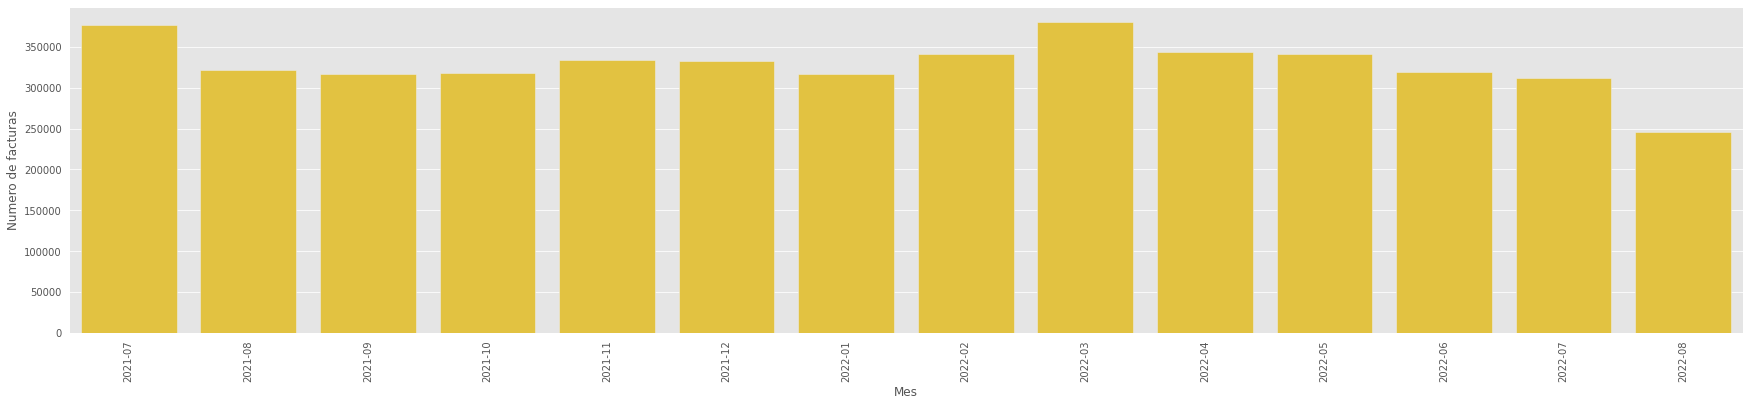

In [56]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_pagos, x = 'index', y='Fecha de emisión_3', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

In [64]:
Importe_por_mes = data_new.fillna(0).groupby("Fecha de emisión_3",as_index = False)['Importe Factura'].agg(sum)
Importe_por_mes

,Fecha de emisión_3,Importe Factura
0,2021-07,16157567.0400
1,2021-08,18212748.7300
2,2021-09,17826034.9300
3,2021-10,13956387.6300
4,2021-11,16484712.7600
5,2021-12,19969221.1000
6,2022-01,20390097.9600
7,2022-02,22900003.3500
8,2022-03,24132414.4700
9,2022-04,25589421.2200


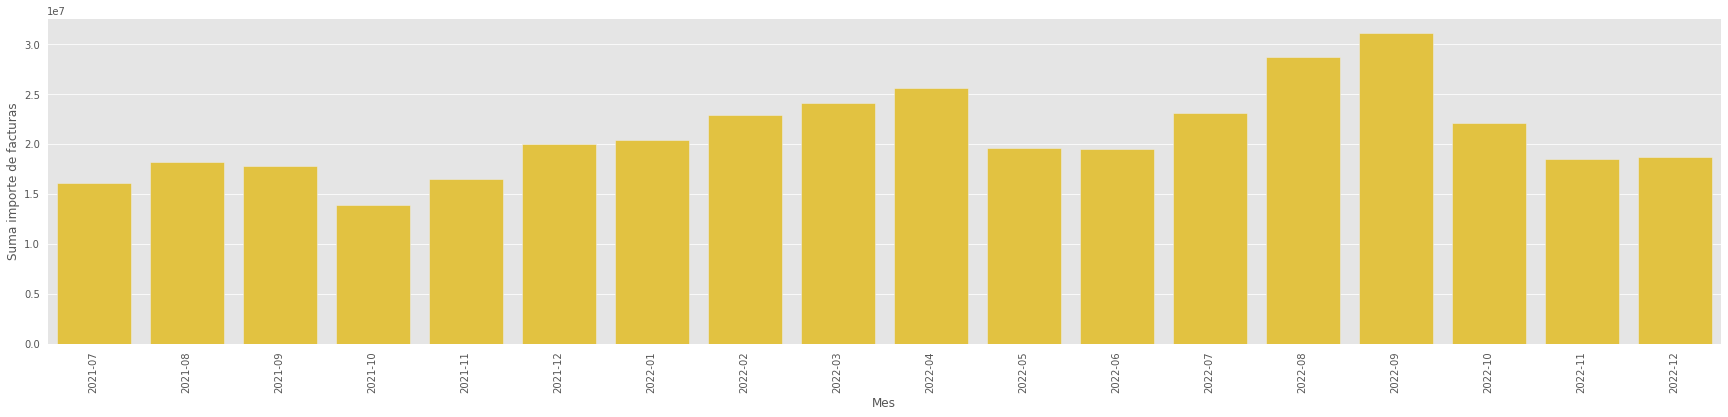

In [65]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Fecha de emisión_3', y='Importe Factura', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Suma importe de facturas')
plt.xticks(rotation=90)
plt.show()

## b) Evolución de las facturas impagadas y recuperadas

In [66]:
data_new.head(1)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01


In [67]:
data_def=data_new[data_new['Impago (si/no)']=='si']

In [68]:
numero_impagos=pd.DataFrame(data_def['Fecha de emisión_3'].value_counts().reset_index().sort_values('index'))
numero_impagos

,index,Fecha de emisión_3
8,2021-07,9593
13,2021-08,8535
15,2021-09,8420
12,2021-10,8555
11,2021-11,9067
7,2021-12,9613
10,2022-01,9220
2,2022-02,10528
0,2022-03,11899
1,2022-04,11037


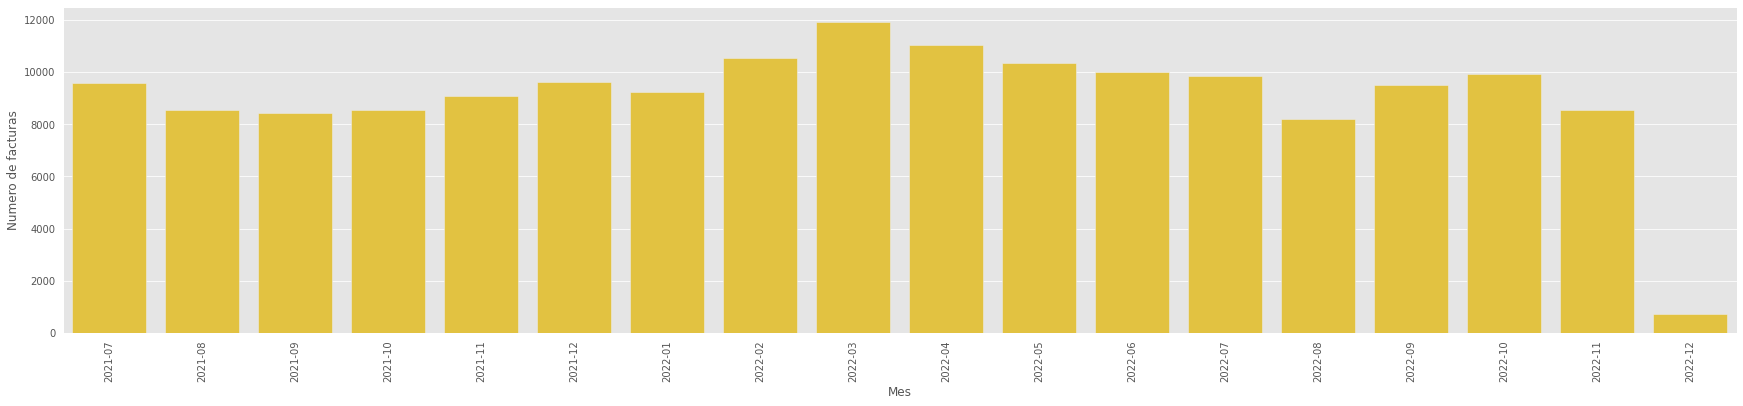

In [69]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_impagos, x = 'index', y='Fecha de emisión_3', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

## c) Evolucion mensual de los importes impagados y recuperado

In [70]:
data_def.head(1)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3
23,Adrián Zapico Laviana,71655179J,"PADRE BUENAVENTURA PAREDES 4, 5º, J, 33001 OVIEDO (ASTURIAS)",33001,inmobiliariazl@hotmail.com,34653986240,71655179J,Electricidad,Agente,ES0026000000838745HC0F,2.0TD,2022010302282.0000,31.6900,si,31.6900,31.6900,Medio,NaN,2019-02-20,2022-01-03,2022-01-13,2022-02-10,2022-01


In [71]:
Importe_por_mes = data_def.fillna(0).groupby("Fecha de emisión_3",as_index = False)['Importe impagado'].agg(sum)
Importe_por_mes

,Fecha de emisión_3,Importe impagado
0,2021-07,556079.1600
1,2021-08,651251.4400
2,2021-09,655896.5500
3,2021-10,544694.6000
4,2021-11,685713.4500
5,2021-12,872295.1000
6,2022-01,842256.0900
7,2022-02,1064668.4600
8,2022-03,1127425.8700
9,2022-04,1330288.6500


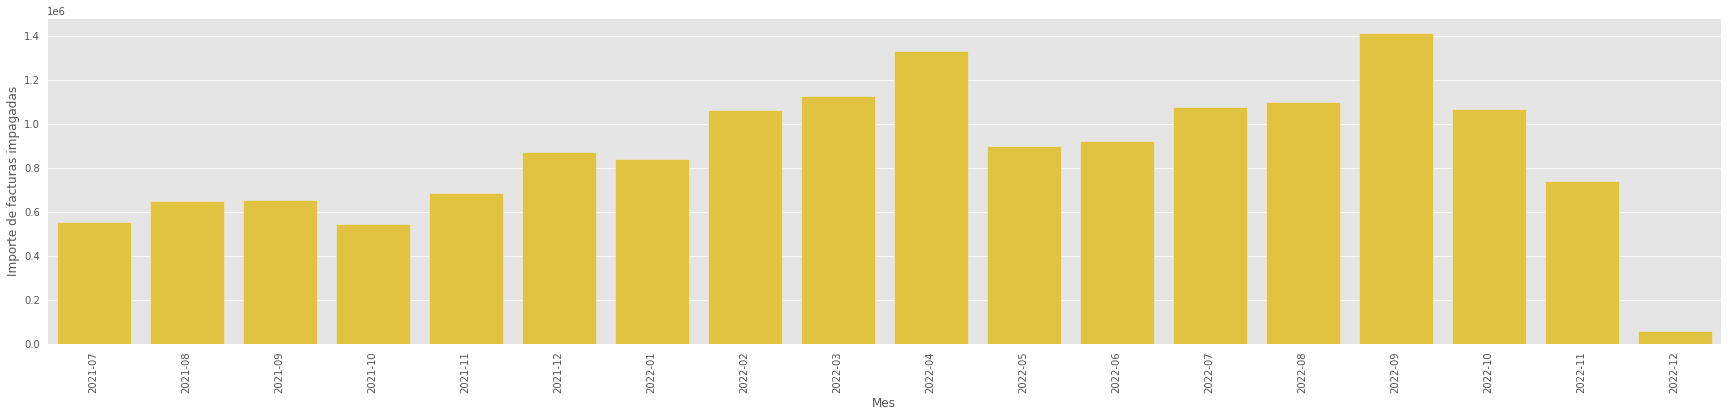

In [72]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Fecha de emisión_3', y='Importe impagado', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas impagadas')
plt.xticks(rotation=90)
plt.show()

In [73]:
Importe_por_mes_2 = data_def.fillna(0).groupby("Fecha de emisión_3",as_index = False)['Importe recuperado'].agg(sum)
Importe_por_mes_2

,Fecha de emisión_3,Importe recuperado
0,2021-07,533236.2200
1,2021-08,626273.9000
2,2021-09,624705.8800
3,2021-10,508449.4300
4,2021-11,622637.8000
5,2021-12,804841.9800
6,2022-01,770315.2200
7,2022-02,944627.3100
8,2022-03,970977.3900
9,2022-04,1148260.5800


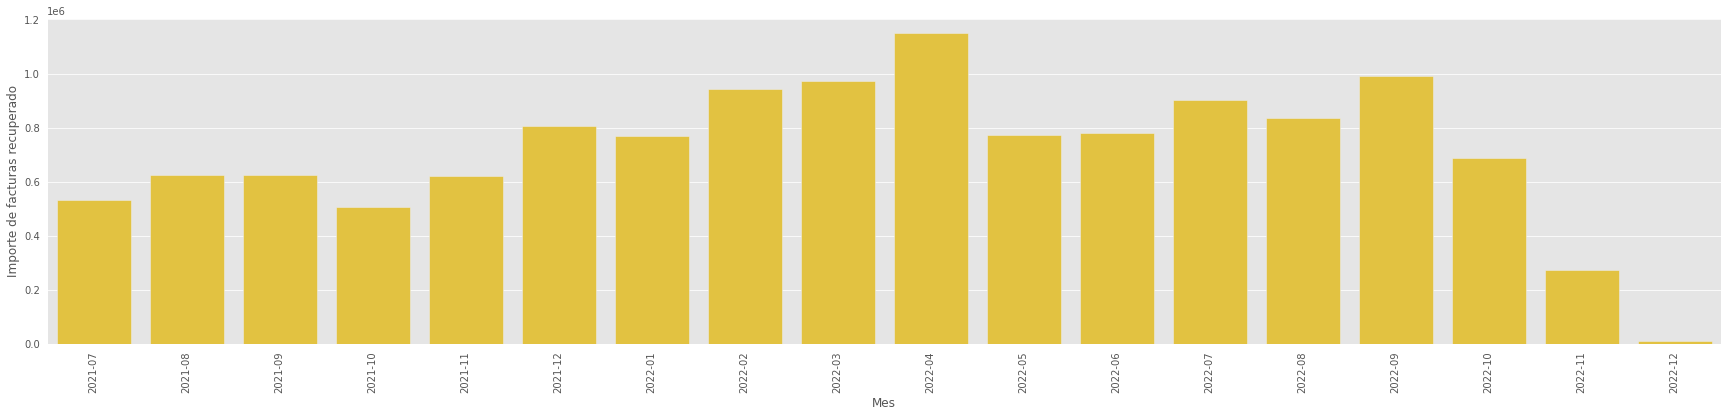

In [74]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes_2, x = 'Fecha de emisión_3', y='Importe recuperado', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas recuperado')
plt.xticks(rotation=90)
plt.show()

In [75]:
data_new.head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01
1,Abdelhadi Driouich,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",04610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,2022010301105.0000,124.9400,no,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN,2022-01


# PUNTO 6. TIPO DE CUOTA

No aplica porque tenemos todas las facturas con su correspondiente pago

# PUNTO 7. IMPORTES NEGATIVOS

- Tenemos importes de factura negativos 87, impagados 33 y recuperados 49. 
  Respecto a los importes negativos en la reunion con cliente de QA0 nos comentan que es para cuadrar el exceso de cobro a los clientes de cuota fija que han pagado mas de lo que correspondía.

Visto en el punto 4

# PUNTO 8. DUPLICADOS

In [65]:
data_new.shape

(4597439, 24)

In [66]:
data_new['ID Factura'].nunique()

4597439

No hay duplicados

# PUNTO 9. FECHAS DE RECUPERACION ANTERIORES A LAS DE VENCIMIENTO

In [57]:
data_rec_ven=data_new[data_new['Fecha recuperación_2']<data_new['Fecha de vencimiento de factura_2'].astype(str).str.slice(0,10)]

In [59]:
print(data_rec_ven.shape)
data_rec_ven.head()

(28, 24)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de vencimiento de factura_3,Fecha de emisión_3
356994,Paulina Alexandra Largo Calderón,26861034R,"URB. NARANJOS DE ALHAMA-BULEVAR NARANJOS JARDIN 5 413, BAJO, 30840 ALHAMA DE MURCIA (MURCIA)",30840,pepa45cordoba@hotmail.com,NaN,26861034R,Electricidad,Agente,ES0021000015876518DY,2.0TD,2022020218078.0000,209.9900,si,209.9900,105.0000,Medio Alto,2022-03-16,2020-12-11,2022-02-02,2022-04-15,2022-03-16,2022-04-15,2022-02
528980,Belén Rocío García Navarro,19833262V,"Mare de Déu de Montiel 0028, 46980 Paterna (VALENCIA)",46980,administracion@concellodapastoriza.es,NaN,19833262V,Electricidad,Agente,ES0021000008300588GT,2.0TD,2022021609085.0000,1968.2400,si,1968.2400,1968.2400,NaN,NaN,2013-12-09,2022-02-16,2022-06-15,2022-06-06,2022-06-15,2022-02
619410,ANGELA FLO LLINAS,53290414N,"PONENT 16, 08777 SANT QUINTI DE MEDIONA (BARCELONA)",08777,montgelika@hotmail.com,34620703729.0000,53290414N,Electricidad,Agente,ES0031405788750001XT0F,2.0TD,2022022214425.0000,158.6000,si,158.6000,158.6000,Muy Alto,NaN,2018-12-11,2022-02-22,2022-06-12,2022-05-30,2022-06-12,2022-02
678407,Juan Carlos Cortes Ortiz,79062867E,"CN MAJADA 11, EDIFICIO PALACIO, BJO-C, VIVIENDA, 38260 Tejina (San Cristóbal de la Laguna) (S.C. TEN",38260,salvucciorinaudo@gmail.com,NaN,79062867E,Electricidad,Agente,ES0031601084385005JD0F,2.0TD,2022022802097.0000,52.7000,si,52.7000,52.7000,Bajo,NaN,2021-06-14,2022-02-28,2022-07-08,2022-04-08,2022-07-08,2022-02
678408,Juan Carlos Cortes Ortiz,79062867E,"CN MAJADA 11, EDIFICIO PALACIO, BJO-C, VIVIENDA, 38260 Tejina (San Cristóbal de la Laguna) (S.C. TEN",38260,salvucciorinaudo@gmail.com,NaN,79062867E,Electricidad,Agente,ES0031601084385005JD0F,2.0TD,2022022802098.0000,52.7300,si,52.7300,52.7300,Bajo,NaN,2021-06-14,2022-02-28,2022-07-28,2022-04-08,2022-07-28,2022-02


Hay 28 casos en los que la fecha de vencimiento es posterior a la fecha de recuperacion. Se levanta esto en la reunion con cliente de QA0.

In [79]:
data_rec_ven[data_rec_ven['Importe recuperado']>data_rec_ven['Importe impagado']].shape

(1, 23)

In [80]:
data_new[data_new['Importe recuperado']>data_new['Importe impagado']]

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3
2271762,Francisca Cano Valencia,28866111F,"Avda Hytasa 0003, 1, A, 41006 Sevilla (SEVILLA)",41006,tecmoluna.gestion@gmail.com,34622071561,28866111F,Electricidad,Agente,ES0031102254318009TE,2.0TD,2022030117376.0000,21.9700,si,21.9700,23.2000,NaN,2022-04-25,2012-03-28,2022-03-01,2022-03-11,NaN,2022-03
5810416,María José Arqués Esquiva,74179448D,"Resid Europa 0071, 1, 03183 Torrevieja (ALACANT/ALICANTE)",03183,pedrobustaca@hotmail.com,34636700098,74179448D,Electricidad,Agente,ES0021000001574310WA,2.0TD,2022090243813.0000,304.8900,si,304.8900,310.0000,NaN,NaN,2014-05-09,2022-09-02,2022-12-01,2022-11-03,2022-09


Se levanta que hay dos casos en los que se recupera mas de lo que se impaga

# PUNTO 10. TOTALES

In [60]:
print('Importe de la factura total: {}'.format(data_new['Importe Factura'].sum()))
print('Importe impagado total: {}'.format(data_new['Importe impagado'].sum()))
print('Importe recuperado total: {}'.format(data_new['Importe recuperado'].sum()))
print('Importe impagado total: {}'.format(data_new['Importe Factura'].sum()-data_new['Importe impagado'].sum()+data_new['Importe recuperado'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*data_new['Importe impagado'].sum()/data_new['Importe Factura'].sum()))
print('Porcentaje de importe recuperado: {}'.format(100*data_new['Importe recuperado'].sum()/data_new['Importe Factura'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(data_new[data_new['Impago (si/no)']=='si'].shape[0])/(data_new.shape[0])))
print('LGD: {}'.format(100*(1-(data_new['Importe recuperado'].sum())/(data_new['Importe impagado'].sum()))))

Importe de la factura total: 278081107.6499998
Importe impagado total: 11374441.849999998
Importe recuperado total: 10203131.069999995
Importe impagado total: 276909796.8699998
Porcentaje de importe impagado: 4.090332473904041
Porcentaje de importe recuperado: 3.6691205512752503
Porcentaje facturas impagadas: 2.7867688945954474
LGD: 10.29774291738107


# PUNTO 11. RECOBROS SIN FECHA

In [82]:
data_new[(data_new['Importe recuperado']>0)&(data_new['Fecha recuperación_2'].isnull())]

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3
1833,June Wood,X4237036E,"Rosa 0008, 60, 03189 Urbanización la Florida (Orihuela) (ALACANT/ALICANTE)",03189,junemarywood@gmail.com,34965718696,X4237036E,Electricidad,Agente,ES0021000010943884KK,2.0TD,2022010303354.0000,2.3100,si,2.3100,0.0100,Medio Alto,2021-12-19,2015-09-22,2022-01-03,2022-01-13,NaN,2022-01
2234,María del Rosario Morgan Almendral,28816095Q,"LOS RODEOS 3, 41880 EL RONQUILLO (SEVILLA)",41880,NaN,34667836635,28816095Q,Electricidad,Agente,ES0031104599989001QY0F,2.0TD,2022010302921.0000,340.3400,si,340.3400,48.3600,Medio,NaN,2021-02-04,2022-01-03,2022-01-13,NaN,2022-01
3198,Víctor Pellico González,02655834R,"RUA PINTOR LAXEIRO 19, 2º, F, 27780 Foz (LUGO)",27780,victor.pellico@gmail.com,34649954383,02655834R,Electricidad,Agente,ES0033620000011519RZ0F,2.0TD,2022010303722.0000,27.9800,si,27.9800,0.0100,NaN,2021-12-19,2020-08-19,2022-01-03,2022-01-13,NaN,2022-01
13106,Marta Byrtek,Y4734991H,"Maestro Caballero 0014, 3, 1, 03004 Alicante-Alacant (ALACANT/ALICANTE)",03004,bejmi@hotmail.com,NaN,Y4734991H,Electricidad,Agente,ES0021000000631362JD,2.0TD,2022010413673.0000,31.6700,si,31.6700,31.6700,Medio Alto,2022-05-05,2014-07-22,2022-01-04,2022-01-14,NaN,2022-01
16311,Ahmed Soussan,Y5398932H,"CMNO AMBILLA 4, 26500 CALAHORRA (LA RIOJA)",26500,saiidkaauki1996@gmail.com,34605126234,Y5398932H,Electricidad,Agente,ES0021000039809906WP,2.0TD,2022010522461.0000,80.3000,si,80.3000,2.4400,Medio Alto,2022-02-08,2021-02-19,2022-01-05,2022-01-15,NaN,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6300213,Diana Gómez Arias,48298128Z,"Pda. Algar Alto 430, 03510 CALLOSA D'EN SARRIA (ALACANT/ALICANTE)",03510,dianagomezarias797@gmail.com,34643955244,48298128Z,Electricidad,Agente,ES0021000000863525XX,2.0TD,2022101802888.0000,47.1800,si,47.1800,39.6500,D,NaN,2021-07-08,2022-10-18,2022-10-28,NaN,2022-10
6319079,Yeisson Andrés Bayona Aparicio,Y4535945Z,"Condesa de la Vega del Pozo 0003, A, 2, Izd, 19001 Guadalajara (GUADALAJARA)",19001,andrespolinecia@gmail.com,34639508255,Y4535945Z,Electricidad,Agente,ES0022000005436500YT1P,2.0TD,2022101903143.0000,130.0200,si,130.0200,1.5300,NaN,NaN,2014-09-16,2022-10-19,2022-10-29,NaN,2022-10
6365074,Babar Alí Begum,55151680A,"Avda L'AMETLLA DE MAR, 17, LC01, 03503 Benidorm (ALACANT/ALICANTE)",03503,NaN,NaN,55151680A,Electricidad,Agente,ES0021000000777039EG,2.0TD,2022102704256.0000,870.3200,si,870.3200,80.0800,Medio,2022-11-25,2019-08-27,2022-10-27,2022-11-04,NaN,2022-10
6375802,Francisco Carlos García Nebreda,13157146L,"MARTIN ALONSO 2, 09197 VILLARMERO (BURGOS)",09197,cgnebreda@gmail.com,NaN,13157146L,Electricidad,Agente,ES0021000012536760RD,2.0TD,2022102813069.0000,35.5600,si,35.5600,18.0600,Medio,NaN,2018-12-04,2022-10-28,2022-11-07,NaN,2022-10


In [83]:
data_new[(data_new['Importe recuperado']>0)&(data_new['Fecha recuperación_2'].isnull())].shape

(374, 23)

Hay 374 facturas que se indica importe recuperado pero no la fecha asociada a esto. Este punto se levanta en la reunión QA0 con cliente.

# PUNTO 12. ACTUALIZACION DEL FICHERO

No aplica

# PUNTO 13. VALORES MAXIMO Y MINIMOS PARA LAS FECHAS DE ALTA Y BAJA

In [61]:
print('La fecha de baja minimima es: {}'.format(data_new['Fecha Baja_2'].dropna().min()))
print('La fecha de baja máxima es: {}'.format(data_new['Fecha Baja_2'].dropna().max()))
print('La fecha de alta minimima es: {}'.format(data_new['Fecha Alta_2'].dropna().min()))
print('La fecha de alta máxima es: {}'.format(data_new['Fecha Alta_2'].dropna().max()))

La fecha de baja minimima es: 1944-05-30
La fecha de baja máxima es: 2023-01-01
La fecha de alta minimima es: 2011-05-23
La fecha de alta máxima es: 2022-11-17


In [62]:
print('La fecha de factura minimima es: {}'.format(data_new['Fecha de emisión_2'].min()))
print('La fecha de factura maxima es: {}'.format(data_new['Fecha de emisión_2'].max()))

La fecha de factura minimima es: 2021-07-01
La fecha de factura maxima es: 2022-08-26


##### El horizonte temporal será considerado desde 2021-07-01 hasta 2022-12-30

Detectamos anomalias entre las fechas de baja y las fechas de alta

In [67]:
len(data_new[(data_new['Fecha Baja_2']<data_new['Fecha Alta_2'])]['Nombre y apellidos '].value_counts())

485

Hay 485 clientes que tienen fecha de baja anterior a la fecha de alta. Esto se levanta en la reunion para revisar QA0

In [68]:
len(data_new[(data_new['Fecha Baja_2']<data_new['Fecha Alta_2'])&(data_new['Fecha Alta_2']>'2021-07-01')]['Nombre y apellidos '].value_counts())

43

Realmente en el horizonte temporal que vamos a considerar solo hay 43 clientes con esta casuistica.

In [90]:
data_new[(data_new['Fecha Baja_2']<data_new['Fecha Alta_2'])&(data_new['Fecha Alta_2']>'2021-07-01')].sort_values('NIF/DNI')

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3
4241932,Juan Carlos Placer Rueda,00812340A,"CARABELOS 59, 1º, D, 28041 MADRID (MADRID)",28041,ghosssttt@hotmail.com,34656811003,00812340A,Electricidad,Agente,ES0022000006306239PV1P,2.0TD,2021121308869.0000,22.4700,no,nan,nan,Medio,2021-10-21,2021-10-22,2021-12-13,2021-12-23,NaN,2021-12
4000102,Juan Carlos Placer Rueda,00812340A,"CARABELOS 59, 1º, D, 28041 MADRID (MADRID)",28041,ghosssttt@hotmail.com,34656811003,00812340A,Electricidad,Agente,ES0022000006306239PV1P,2.0TD,2021112206797.0000,15.0600,no,nan,nan,Medio,2021-10-21,2021-10-22,2021-11-22,2021-12-02,NaN,2021-11
1280154,Francisco Augustin Molero,02520290L,"PICO DE LOS ARTILLEROS 00156 3 A, 28030 MADRID (MADRID)",28030,franciscoaugustin@gmail.com,34609060494,02520290L,Electricidad,Agente,ES0022000006473565SH1P,2.0TD,2021081916580.0000,5.8900,no,nan,nan,Medio Bajo,2021-08-05,2021-08-06,2021-08-19,2021-08-29,NaN,2021-08
4236853,Francisco Augustin Molero,02520290L,"PICO DE LOS ARTILLEROS 00156 3 A, 28030 MADRID (MADRID)",28030,franciscoaugustin@gmail.com,34609060494,02520290L,Electricidad,Agente,ES0022000006473565SH1P,2.0TD,2021121308685.0000,17.6000,no,nan,nan,Medio Bajo,2021-08-05,2021-08-06,2021-12-13,2021-12-23,NaN,2021-12
5292061,Francisco Augustin Molero,02520290L,"PICO DE LOS ARTILLEROS 00156 3 A, 28030 MADRID (MADRID)",28030,franciscoaugustin@gmail.com,34609060494,02520290L,Electricidad,Agente,ES0022000006473565SH1P,2.0TD,2021092019468.0000,18.2200,no,nan,nan,Medio Bajo,2021-08-05,2021-08-06,2021-09-20,2021-09-30,NaN,2021-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689067,Volker Torsten Dirk Kroll,Y8731653Q,"DE LES ILLES ALAND 21, 07688 CALA MURADA (BALEARS)",07688,bianca@krollimmo.de,NaN,Y8731653Q,Electricidad,Agente,ES0031500714135001YG0F,2.0TD,2022022822147.0000,163.7500,no,nan,nan,Medio,2021-07-28,2021-07-29,2022-02-28,2022-03-10,NaN,2022-02
3741312,Volker Torsten Dirk Kroll,Y8731653Q,"DE LES ILLES ALAND 21, 07688 CALA MURADA (BALEARS)",07688,bianca@krollimmo.de,NaN,Y8731653Q,Electricidad,Agente,ES0031500714135001YG0F,2.0TD,2021110201665.0000,478.1700,no,nan,nan,Medio,2021-07-28,2021-07-29,2021-11-02,2021-11-12,NaN,2021-11
3728188,Volker Torsten Dirk Kroll,Y8731653Q,"DE LES ILLES ALAND 21, 07688 CALA MURADA (BALEARS)",07688,bianca@krollimmo.de,NaN,Y8731653Q,Electricidad,Agente,ES0031500714135001YG0F,2.0TD,2022062900694.0000,28.7500,no,nan,nan,Medio,2021-07-28,2021-07-29,2022-06-29,2022-08-10,NaN,2022-06
3393829,Volker Torsten Dirk Kroll,Y8731653Q,"DE LES ILLES ALAND 21, 07688 CALA MURADA (BALEARS)",07688,bianca@krollimmo.de,NaN,Y8731653Q,Electricidad,Agente,ES0031500714135001YG0F,2.0TD,2022060106913.0000,104.3500,no,nan,nan,Medio,2021-07-28,2021-07-29,2022-06-01,2022-07-01,NaN,2022-06


Nos damos cuenta que la fecha de baja esta un dia antes que la de alta, ppor lo que entendemos que se pasa la fecha de baja de un contrato anterior y por tanto la fecha de baja tiene que estar desinformada

In [27]:
data_new['Fecha Baja_2']=np.where((data_new['Fecha Baja_2']<data_new['Fecha Alta_2'])&(data_new['Fecha Alta_2']>'2021-07-01'),np.nan,data_new['Fecha Baja_2'])

# PUNTO 14. DIAS DE RETRASO

Construir los dias de retraso es necesario para calcular el target.

In [71]:
# Formato fecha
def cambiar_fec_recu(Fecha):
    try:
        return datetime.strptime(Fecha, '%Y-%m-%d')
    except:
        if Fecha==Fecha:
            print(Fecha)
        return datetime.strptime('2022-12-30', '%Y-%m-%d')

In [70]:
data_new['Fecha recuperación_auxiliar']=data_new['Fecha recuperación_2'].apply(cambiar_fec_recu)

In [72]:
# Construccion de los dias en default
data_new['dias_en_default']=np.where(data_new['Impago (si/no)']=='si' , 
                                     data_new['Fecha recuperación_auxiliar'] - data_new['Fecha de vencimiento de factura_3'] , 
                                     data_new['Fecha recuperación_auxiliar']-data_new['Fecha recuperación_auxiliar'])

In [73]:
# Formato numerico
data_new['dias_en_default'] = pd.to_numeric(data_new['dias_en_default'].dropna().astype(str).str.split(' ').apply(lambda x: x[0]))

#### Calculamos el target a 90 y 120 dias

Calculamos el target a 90 y 120 dias porque no sabemos cual de los dos usaremos

In [74]:
# Target a 90 dias
data_new['Default_90_dias'] = np.where(data_new['dias_en_default']>90, 1, 0)
print('Numero de facturas con mas de 90 dias de atraso: {}'.format(data_new['Default_90_dias'].sum()))
print('Porcentaje de facturas con mas de 90 dias de atraso: {}'.format(100*(data_new['Default_90_dias'].sum()/data_new['Default_90_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 90 dias de atraso: {}'.format(100*(data_new[data_new['Default_90_dias']>0]['Importe impagado'].sum()/data_new['Importe Factura'].sum())))

Numero de facturas con mas de 90 dias de atraso: 22028
Porcentaje de facturas con mas de 90 dias de atraso: 0.47913631915507743
Porcentaje de dinero impagado mas de 90 dias de atraso: 0.8345268003322418


In [75]:
# Target a 120 dias
data_new['Default_120_dias'] = np.where(data_new['dias_en_default']>120, 1, 0)
print('Numero de facturas con mas de 120 dias de atraso: {}'.format(data_new['Default_120_dias'].sum()))
print('Porcentaje de facturas con mas de 120 dias de atraso: {}'.format(100*(data_new['Default_120_dias'].sum()/data_new['Default_120_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 120 dias de atraso: {}'.format(100*(data_new[data_new['Default_120_dias']>0]['Importe impagado'].sum()/data_new['Importe Factura'].sum())))

Numero de facturas con mas de 120 dias de atraso: 14645
Porcentaje de facturas con mas de 120 dias de atraso: 0.31854691274859764
Porcentaje de dinero impagado mas de 120 dias de atraso: 0.5809413820493322


In [22]:
data_new.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_new_formatos_2.csv',sep=';', index=False)

#### Si una factura es mora, el cliente es moroso. Creamos esta variable

In [76]:
data_def_pers=data_new.groupby(['NIF/DNI','CUPS'],as_index = False)[['Default_120_dias','Default_90_dias']].agg(Default_120_dias_pers = ('Default_120_dias', max), Default_90_dias_pers = ('Default_90_dias', max))
data_def_pers

,NIF/DNI,CUPS,Default_120_dias_pers,Default_90_dias_pers
0,00000012DI63217,ES0022000007822763AJ1P,0,0
1,00002156V,ES0031101437547001BT0F,0,0
2,00002909B,ES0021000004651381LL,0,0
3,00002909B,ES0021000005169213VY,0,0
4,00003459D,ES0021000004120435GM,0,0
...,...,...,...,...
381036,y3097833t,ES0021000019534106NL,0,0
381037,y3449610s,ES0031607607069002RH,0,0
381038,y3924532x,ES0031406045476007HY0F,1,1
381039,y3936446x,ES0031500548639001PK0F,0,0


In [77]:
data_new = data_new.merge(data_def_pers, how='left', on=['NIF/DNI','CUPS'])

# PUNTO 15. EMPRESAS

En España los DNI de personas que no son fisicas se identifican por comenzar con las letras de la A a la H, J, N, de la Ps a la S y U, V y W. Deben ser eliminados

In [78]:
data_new = data_new[data_new['NIF/DNI'].astype(str).apply(lambda x: re.search('^[A-H]+', x)).isnull()]
data_new = data_new[data_new['NIF/DNI'].astype(str).apply(lambda x: re.search('^[P-S]+', x)).isnull()]
data_new = data_new[data_new['NIF/DNI'].astype(str).apply(lambda x: re.search('^[J]+', x)).isnull()]
data_new = data_new[data_new['NIF/DNI'].astype(str).apply(lambda x: re.search('^[N]+', x)).isnull()]
data_new = data_new[data_new['NIF/DNI'].astype(str).apply(lambda x: re.search('^[U-W]+', x)).isnull()]
print('Number of records for physical people: {0:.0f}\nNumber of features: {1:.0f}'.format(data_new.shape[0], data_new.shape[1]))

Number of records for physical people: 4590369
Number of features: 30


In [80]:
print(data_new.shape)
data_new.head()

(4590369, 30)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de vencimiento de factura_3,Fecha de emisión_3,Fecha recuperación_auxiliar,dias_en_default,Default_90_dias,Default_120_dias,Default_120_dias_pers,Default_90_dias_pers
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01-13,2022-01,2022-12-30,0,0,0,0,0
1,Abdelhadi Driouich,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",04610,driwchabdelahdig@gmail.com,34631070554.0000,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,2022010301105.0000,124.9400,no,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN,2022-01-13,2022-01,2022-12-30,0,0,0,0,0
2,Abdelkader Jabbour Koutaibi,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",03360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,2022010300951.0000,21.4600,no,nan,nan,Bajo,NaN,2021-07-30,2022-01-03,2022-01-13,NaN,2022-01-13,2022-01,2022-12-30,0,0,0,0,0
3,Abdelkrim Moutouk,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",07200,maesma@gmail.com,34632543079.0000,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,2022010301004.0000,20.3500,no,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN,2022-01-13,2022-01,2022-12-30,0,0,0,1,1
4,Abdenbi Bouighejd Zenouari,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243.0000,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,2022010304946.0000,132.0000,no,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN,2022-01-13,2022-01,2022-12-30,0,0,0,0,0


# Tiempos de permanencia en la cartera

Una vez quitadas las empresas y hechas las correcciones permanentes me dispongo a calcular el tiempo de permanencia en la cartera para todos los clientes

In [45]:
print('Numero de facturas de la data total: {}'.format(data_new.shape[0]))
print('Numero de cliente/CUPS de la data total: {}'.format(data_new.groupby('ID Cliente')['CUPS'].nunique().sum()))

data_fec_baja_inf = data_new[data_new['Fecha Baja_2'].notnull()]
data_fec_baja_no_inf = data_new[data_new['Fecha Baja_2'].isnull()]

print('Numero de facturas de la data con fecha de baja informada: {}'.format(data_fec_baja_inf.shape[0]))
print('Numero de cliente/CUPS de la data fecha de baja informada: {}'.format(data_fec_baja_inf.groupby('ID Cliente')['CUPS'].nunique().sum()))
print('Numero de facturas de la data con fecha de baja desinformada: {}'.format(data_fec_baja_no_inf.shape[0]))
print('Numero de cliente/CUPS de la data fecha de baja desinformada: {}'.format(data_fec_baja_no_inf.groupby('ID Cliente')['CUPS'].nunique().sum()))

#print('Numero de facturas de la data con fecha de baja informada electricidad: {}'.format(data_fec_baja_inf[data_fec_baja_inf['Tipo de producto']=='Electricidad'].shape[0]))
#print('Numero de cliente/CUPS de la data con fecha de baja informada electricidad: {}'.format(data_fec_baja_inf[data_fec_baja_inf['Tipo de producto']=='Electricidad'].groupby('ID Cliente')['CUPS'].nunique().sum()))
#print('Numero de facturas de la data con fecha de baja desinformada electricidad: {}'.format(data_fec_baja_no_inf[data_fec_baja_no_inf['Tipo de producto']=='Electricidad'].shape[0]))
#print('Numero de cliente/CUPS de la data con fecha de baja desinformada electricidad: {}'.format(data_fec_baja_no_inf[data_fec_baja_no_inf['Tipo de producto']=='Electricidad'].groupby('ID Cliente')['CUPS'].nunique().sum()))

#print('Numero de facturas de la data con fecha de baja informada gas: {}'.format(data_fec_baja_inf[data_fec_baja_inf['Tipo de producto']=='Gas'].shape[0]))
#print('Numero de cliente/CUPS de la data con fecha de baja informada gas: {}'.format(data_fec_baja_inf[data_fec_baja_inf['Tipo de producto']=='Gas'].groupby('ID Cliente')['CUPS'].nunique().sum()))
#print('Numero de facturas de la data con fecha de baja desinformada gas: {}'.format(data_fec_baja_no_inf[data_fec_baja_no_inf['Tipo de producto']=='Gas'].shape[0]))
#print('Numero de cliente/CUPS de la data con fecha de baja desinformada gas: {}'.format(data_fec_baja_no_inf[data_fec_baja_no_inf['Tipo de producto']=='Gas'].groupby('ID Cliente')['CUPS'].nunique().sum()))

Numero de facturas de la data total: 6213388
Numero de cliente/CUPS de la data total: 434888
Numero de facturas de la data con fecha de baja informada: 1354505
Numero de cliente/CUPS de la data fecha de baja informada: 122667
Numero de facturas de la data con fecha de baja desinformada: 4858883
Numero de cliente/CUPS de la data fecha de baja desinformada: 324730


## Si tienen fecha de baja informada

In [38]:
data_new.groupby('ID Cliente')['CUPS'].nunique().sum()

434888

In [46]:
data_fec_baja_inf.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2022010301004.0000,20.3500,no,nan,nan,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304946.0000,132.0000,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN
5,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304947.0000,44.9200,no,nan,nan,nan,nan,Medio Bajo,2022-10-20,2021-10-22,2022-01-03,2022-01-13,NaN
6,Abdenbi Bouighejd Zenouari,nan,49509771V,"BDA MARIA AUXILIADORA 215, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011001477WP0F,2.0TD,nan,2022010304952.0000,38.4500,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN
7,Abdenbi Bouighejd Zenouari,nan,49509771V,"BDA MARIA AUXILIADORA 215, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011001477WP0F,2.0TD,nan,2022010304953.0000,12.6900,no,nan,nan,nan,nan,Medio Bajo,2022-10-20,2021-10-22,2022-01-03,2022-01-13,NaN


In [52]:
data_fec_baja_inf['Fecha Alta_3']=np.where(data_fec_baja_inf['Fecha Alta_2'].isnull(), (data_fec_baja_inf['Fecha de emisión_2']), data_fec_baja_inf['Fecha Alta_2'])
#data_fec_baja_inf['Fecha Baja_2']=data_fec_baja_inf['Fecha Baja_2'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_fec_baja_inf['Fecha Alta_3']=data_fec_baja_inf['Fecha Alta_3'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_fec_baja_inf['tenure'] = data_fec_baja_inf['Fecha Baja_2'] - data_fec_baja_inf['Fecha Alta_3'] 
data_fec_baja_inf['tenure']=data_fec_baja_inf['tenure'].astype(str).str.split(' ').apply(lambda x: x[0])
data_fec_baja_inf['tenure']=pd.to_numeric(data_fec_baja_inf['tenure'], errors='coerce')

In [56]:
data_fec_baja_inf[data_fec_baja_inf['Fecha Alta_2'].isnull()]['ID Cliente'].value_counts()

34991168A    13
07387271Q    13
47506588L    11
76113560M     7
06000367N     6
32760629G     5
36565831V     5
Y8667633M     4
76101360H     4
29128063N     4
48289528q     2
72062793K     2
54073171X     2
04607942F     2
10898474Q     2
10186637Y     2
05719665W     1
25300568Q     1
41399083A     1
Name: ID Cliente, dtype: int64

In [86]:
# Ejemplo de que tienen facturas con fecha posterior a la fecha de baja
data_new[data_new['ID Cliente']=='34991168A'][['ID Cliente','CUPS','Fecha de vencimiento de factura_2','Fecha Alta_2','Fecha Baja_2']].head()

,ID Cliente,CUPS,Fecha de vencimiento de factura_2,Fecha Alta_2,Fecha Baja_2
1366391,34991168A,ES0022000004765769FH,2021-09-04,2021-07-22,2021-08-27
1366392,34991168A,ES0022000004765768FV,2021-09-04,2021-07-22,2021-08-28
1724189,34991168A,ES0022000004765773FE,2022-08-05,NaN,2021-08-28
2076029,34991168A,ES0022000004765773FE,2022-09-06,NaN,2021-08-28
2295640,34991168A,ES0022000004765773FE,2022-03-12,NaN,2021-08-28


In [58]:
data_fec_baja_inf[data_fec_baja_inf['ID Cliente']=='34991168A'][['ID Cliente','CUPS','Fecha Alta_2','Fecha Alta_3','Fecha Baja_2','tenure']].head()
# Nos quedamos con el maximo tenure por cliente/cups

,ID Cliente,CUPS,Fecha Alta_2,Fecha Alta_3,Fecha Baja_2,tenure
1366391,34991168A,ES0022000004765769FH,2021-07-22,2021-07-22,2021-08-27,36
1366392,34991168A,ES0022000004765768FV,2021-07-22,2021-07-22,2021-08-28,37
1724189,34991168A,ES0022000004765773FE,NaN,2022-07-26,2021-08-28,-332
2076029,34991168A,ES0022000004765773FE,NaN,2022-08-29,2021-08-28,-366
2295640,34991168A,ES0022000004765773FE,NaN,2022-03-02,2021-08-28,-186


In [71]:
tenure_cliente_cups = data_fec_baja_inf.groupby(['ID Cliente','CUPS']).agg({'tenure': 'max'})
tenure_cliente_cups.reset_index(inplace=True)

In [78]:
data_fec_baja_inf.drop(columns=['tenure__cli_cups'], inplace=True)

In [79]:
data_fec_baja_inf = data_fec_baja_inf.merge(tenure_cliente_cups, how = 'inner', on=['ID Cliente','CUPS']).rename(columns={'tenure_x':'tenure', 'tenure_y':'tenure__cli_cups'})
data_fec_baja_inf.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha Alta_3,tenure,tenure__cli_cups
0,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2022010301004.0000,20.3500,no,nan,nan,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN,2019-11-09,724,724
1,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2021070815224.0000,9.5400,si,9.5400,9.5400,nan,nan,Medio,2021-11-02,2019-11-09,2021-07-08,2021-07-18,2022-02-18,2019-11-09,724,724
2,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2021080914767.0000,14.0000,si,14.0000,14.0000,nan,nan,Medio,2021-11-02,2019-11-09,2021-08-09,2021-08-19,2022-02-18,2019-11-09,724,724
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2021120219939.0000,30.9400,si,30.9400,30.9400,nan,nan,Medio,2021-11-02,2019-11-09,2021-12-02,2021-12-12,2022-02-18,2019-11-09,724,724
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304946.0000,132.0000,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN,2020-12-01,323,363


In [84]:
data_fec_baja_inf_cli_cups = data_fec_baja_inf[['ID Cliente','CUPS','tenure__cli_cups']].drop_duplicates()
data_fec_baja_inf_cli_cups['tenure__cli_cups'].mean()

1225.9687038893917

### Si tienen fecha de baja desinformada 

In [85]:
data_fec_baja_no_inf['Fecha Alta_3']=np.where(data_fec_baja_no_inf['Fecha Alta_2'].isnull(), (data_fec_baja_no_inf['Fecha de emisión_2']), data_fec_baja_no_inf['Fecha Alta_2'])
data_fec_baja_no_inf['Fecha Baja_3']=np.where((data_fec_baja_no_inf['Fecha Baja_2'].isnull())|(data_fec_baja_no_inf['Fecha Baja_2']>'2022-12-30'), '2022-12-30', data_fec_baja_no_inf['Fecha Baja_2'])
data_fec_baja_no_inf['Fecha Alta_3']=data_fec_baja_no_inf['Fecha Alta_3'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_fec_baja_no_inf['Fecha Baja_3']=data_fec_baja_no_inf['Fecha Baja_3'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_fec_baja_no_inf['tenure'] = data_fec_baja_no_inf['Fecha Baja_3'] - data_fec_baja_inf['Fecha Alta_3'] 
data_fec_baja_no_inf['tenure']=data_fec_baja_no_inf['tenure'].astype(str).str.split(' ').apply(lambda x: x[0])
data_fec_baja_no_inf['tenure']=pd.to_numeric(data_fec_baja_no_inf['tenure'], errors='coerce')

TypeError: strptime() argument 1 must be str, not float

# PUNTO 16. TENURE

In [88]:
data_new.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
0,Aarón Tortosa Moscardó,nan,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,nan,2022010304356.0000,61.8900,no,nan,nan,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN
1,Abdelhadi Driouich,nan,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",4610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,nan,2022010301105.0000,124.9400,no,nan,nan,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN
2,Abdelkader Jabbour Koutaibi,nan,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",3360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,nan,2022010300951.0000,21.4600,no,nan,nan,nan,nan,Bajo,NaN,2021-07-30,2022-01-03,2022-01-13,NaN
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2022010301004.0000,20.3500,no,nan,nan,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304946.0000,132.0000,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN


In [89]:
data_new['Fecha Baja_3']=np.where((data_new['Fecha Baja_2'].isnull())|(data_new['Fecha Baja_2']>'2022-12-30'), '2022-12-30', data_new['Fecha Baja_2'])

In [90]:
# Hay que añadir como fecha de alta la fecha de emision minima por cliente y cups
data_new['Fecha Alta_3']=np.where(data_new['Fecha Alta_2'].isnull(), (data_new['Fecha de emisión_2']), data_new['Fecha Alta_2'])

In [91]:
data_new[data_new['Fecha Alta_2'].isnull()]

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha Baja_3,Fecha Alta_3
3751,Ana Ballesteros Arias,nan,04607942F,"SAN COSME 22, 4, c, 16002 CUENCA (CUENCA)",16002,prop.c.h.ilona@gmail.com,34777777777,04607942F,Gas,Agente,ES0220040013785653HP,RL01,nan,62022010400456.0000,2.6500,no,nan,nan,nan,nan,Medio Alto,2021-12-08,NaN,2022-01-04,2022-01-14,NaN,2021-12-08,2022-01-04
15806,Vasile Claudiu Benche,nan,X5880909Q,"Avda Valencia 0144, 1, 46140 Ademuz (VALENCIA)",46140,magnetcoworking@gmail.com,NaN,X5880909Q,Electricidad,Agente,ES0031300112365003GF0F,2.0TD,nan,2022010401057.0000,50.5100,no,nan,nan,nan,nan,NaN,NaN,NaN,2022-01-04,2022-01-14,NaN,2022-12-30,2022-01-04
17436,Antonio Lorca Fructuoso,nan,21895269M,"PABLO NERUDA 23, 03193 SAN MIGUEL DE SALINAS (ALACANT/ALICANTE)",3193,isabemaria1958@gmail.com,34618716004,21895269M,Electricidad,Agente,ES0021000001424181YHOP,2.0TD,nan,2022010509300.0000,21.7700,no,nan,nan,nan,nan,Bajo,NaN,NaN,2022-01-05,2022-01-15,NaN,2022-12-30,2022-01-05
20838,Isabel Miguel Zapata,nan,00380452D,"COSTA D'EN DEIA 7, 2, B, 07702 MAO-MAHON (BALEARS)",7700,i.demiguel@yahoo.com,NaN,00380452D,Electricidad,Agente,ES0031500017074002ZM,2.0TD,nan,2022010507776.0000,24.3000,no,nan,nan,nan,nan,Bajo,NaN,NaN,2022-01-05,2022-01-15,NaN,2022-12-30,2022-01-05
29183,Carmen López Pons,nan,20314850P,"Pérez Galdós 0014, Bjo, 46824 Quesa (VALENCIA)",46824,NaN,34699805767,20314850P,Electricidad,Agente,ES0021000008367770AE,2.0TD,nan,2022010601748.0000,76.6500,si,76.6500,76.6500,nan,nan,Medio Alto,NaN,NaN,2022-01-06,2022-01-16,2022-01-28,2022-12-30,2022-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6370228,Rosa María Burgos Arroyo,nan,46070491L,"AVDA LA ESTACION 50, B, 3º 8, B, 14500 PUENTE GENIL (CORDOBA)",#N/D,02bar3c@gmail.com,34605043514,46070491L,Electricidad,Agente,ES0031101441932030VX0F,2.0TD,nan,2022102704839.0000,10.5000,si,10.5000,0.0000,nan,nan,Bajo,NaN,NaN,2022-10-27,2022-11-04,NaN,2022-12-30,2022-10-27
6370229,Rosa María Burgos Arroyo,nan,46070491L,"AVDA LA ESTACION 50, B, 3º 8, B, 14500 PUENTE GENIL (CORDOBA)",#N/D,02bar3c@gmail.com,34605043514,46070491L,Electricidad,Agente,ES0031101441932030VX0F,2.0A,nan,2022102704834.0000,124.0600,si,124.0600,0.0000,nan,nan,Bajo,NaN,NaN,2022-10-27,2022-11-04,NaN,2022-12-30,2022-10-27
6370230,Rosa María Burgos Arroyo,nan,46070491L,"AVDA LA ESTACION 50, B, 3º 8, B, 14500 PUENTE GENIL (CORDOBA)",#N/D,02bar3c@gmail.com,34605043514,46070491L,Electricidad,Agente,ES0031101441932030VX0F,2.0A,nan,2022102704835.0000,7.5100,si,7.5100,0.0000,nan,nan,Bajo,NaN,NaN,2022-10-27,2022-11-04,NaN,2022-12-30,2022-10-27
6393713,Rafael Coro Collado,nan,09369194Y,"CHALANA 102, 33560 URBANIZACION ASTURSELLA (RIBADESELLA) (ASTURIAS)",33560.0000,NaN,NaN,09369194Y,Electricidad,Agente,ES0026000010976018CC0F,2.0TD,nan,2022103103966.0000,3.5600,no,nan,nan,nan,nan,Bajo,NaN,NaN,2022-10-31,2022-11-10,NaN,2022-12-30,2022-10-31


In [92]:
data_new['Fecha Baja_3'].isnull().sum()

0

In [93]:
data_new['Fecha Alta_3'].isnull().sum()

1

In [94]:
data_new['Fecha Baja_3']=data_new['Fecha Baja_3'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [97]:
data_new = data_new[data_new['Fecha Alta_3'].notnull()]

In [98]:
data_new['Fecha Alta_3']=data_new['Fecha Alta_3'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [99]:
data_new['tenure'] = data_new['Fecha Baja_3'] - data_new['Fecha Alta_3'] 

In [100]:
data_new['tenure']=data_new['tenure'].astype(str).str.split(' ').apply(lambda x: x[0])
data_new['tenure']=pd.to_numeric(data_new['tenure'], errors='coerce')

In [101]:
data_new.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha Baja_3,Fecha Alta_3,tenure
0,Aarón Tortosa Moscardó,nan,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,nan,2022010304356.0000,61.8900,no,nan,nan,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-12-30,2020-08-18,864
1,Abdelhadi Driouich,nan,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",4610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,nan,2022010301105.0000,124.9400,no,nan,nan,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN,2022-12-30,2021-07-22,526
2,Abdelkader Jabbour Koutaibi,nan,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",3360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,nan,2022010300951.0000,21.4600,no,nan,nan,nan,nan,Bajo,NaN,2021-07-30,2022-01-03,2022-01-13,NaN,2022-12-30,2021-07-30,518
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2022010301004.0000,20.3500,no,nan,nan,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN,2021-11-02,2019-11-09,724
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304946.0000,132.0000,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN,2021-10-20,2020-12-01,323


In [107]:
data_new.groupby('ID Cliente')['CUPS'].nunique().sum()

434888

In [106]:
data_new[data_new['tenure']<0].groupby('ID Cliente')['CUPS'].nunique().sum()

542

In [125]:
data = data_new[data_new['tenure']>=0].drop_duplicates(subset=['ID Cliente','CUPS','tenure','Fecha Baja_2','Fecha Baja_3'])

In [126]:
data.shape

(455123, 29)

In [129]:
data[data['Fecha Baja_2']>'2022-12-30']

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha Baja_3,Fecha Alta_3,tenure
1679850,Francisco López Jiménez,nan,75581847Y,"RAFAEL ALBERTI 8, 14548 Montalbán de Córdoba (CORDOBA)",14548,NaN,NaN,75581847Y,Electricidad,Agente,ES0143000000203407WZ0F,2.0TD,nan,2022071916804.0000,70.2000,no,nan,nan,nan,nan,Bajo,2023-01-01,2022-06-14,2022-07-19,2022-07-29,NaN,2022-12-30,2022-06-14,199


In [123]:
data[(data['tenure']==0)].shape[0]

43

In [127]:
data[(data['tenure']>=0)&(data['tenure']<180)].shape[0]/data.shape[0]

0.0739228735968079

In [128]:
data[(data['tenure']>=0)&(data['tenure']<365)].shape[0]/data.shape[0]

0.13569738290528055

In [134]:
data[(data['tenure']>=0)&(data['tenure']<365)&(data['Fecha Baja_2'].isnull())].shape[0]/data[(data['tenure']>=0)&(data['tenure']<365)].shape[0]

0.5865218024903253

In [135]:
data[(data['tenure']>=0)&(data['tenure']<365)&(data['Fecha Baja_2'].notnull())].shape[0]/data[(data['tenure']>=0)&(data['tenure']<365)].shape[0]

0.4134781975096747

In [137]:
data[(data['tenure']>=0)&(data['tenure']<180)&(data['Fecha Baja_2'].isnull())].shape[0]/data[(data['tenure']>=0)&(data['tenure']<180)].shape[0]

0.5425335869694448

In [138]:
data[(data['tenure']>=0)&(data['tenure']<180)&(data['Fecha Baja_2'].notnull())].shape[0]/data[(data['tenure']>=0)&(data['tenure']<180)].shape[0]

0.45746641303055524

In [139]:
data[(data['tenure']>=0)&(data['tenure']<365)]['tenure'].mean()

176.7273109992066

In [140]:
data[(data['tenure']>=0)&(data['tenure']<180)]['tenure'].mean()

97.26171085483296

In [118]:
print(data[data['tenure']>=0]['tenure'].quantile(0.05))
print(data[data['tenure']>=0]['tenure'].quantile(0.1))

print(data[data['tenure']>=0]['tenure'].describe())

print(data[data['tenure']>=0]['tenure'].quantile(0.9))
print(data[data['tenure']>=0]['tenure'].quantile(0.95))

128.0
260.0
count   455104.0000
mean      1456.9327
std       1021.8925
min          0.0000
25%        601.0000
50%       1248.0000
75%       2193.0000
max       4239.0000
Name: tenure, dtype: float64
3034.0
3363.0


Datos que dimos el 22/03/2023 al equipo por el canal de Fenie. Contienen fallos por la manera de calcular el tenure, pero posteriormente Victor y Carlos lo hicieron bien en el notebook de Calculadora, aunque estos datos no se los dimos al equipo por el canal
Media = 1456
Mediana = 1248
Clientes con tenure < 365 = 13.56%
Clientes con tenure < 180 = 7.39%

In [ ]:
data_new['Fecha Baja_4']=np.where((data_new['Fecha Baja_2'].isnull())|(data_new['Fecha Baja_2']>'2022-03-31'), '2022-03-31', data_new['Fecha Baja_2'])

In [ ]:
data_new['Fecha Baja_4']=pd.to_datetime(data_new['Fecha Baja_4'],format='%Y-%m-%d', errors='coerce')

In [ ]:
data_new['tenure_hasta_marzo'] = data_new['Fecha Baja_4'] - data_new['Fecha Alta_3'] 

In [ ]:
data_new['tenure_hasta_marzo']=data_new['tenure_hasta_marzo'].astype(str).str.split(' ').apply(lambda x: x[0])
data_new['tenure_hasta_marzo']=pd.to_numeric(data_new['tenure_hasta_marzo'], errors='coerce')

### Distribucion de Tenure

In [87]:
data_new.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
0,Aarón Tortosa Moscardó,nan,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,nan,2022010304356.0000,61.8900,no,nan,nan,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN
1,Abdelhadi Driouich,nan,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",4610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,nan,2022010301105.0000,124.9400,no,nan,nan,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN
2,Abdelkader Jabbour Koutaibi,nan,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",3360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,nan,2022010300951.0000,21.4600,no,nan,nan,nan,nan,Bajo,NaN,2021-07-30,2022-01-03,2022-01-13,NaN
3,Abdelkrim Moutouk,nan,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,nan,2022010301004.0000,20.3500,no,nan,nan,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN
4,Abdenbi Bouighejd Zenouari,nan,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,nan,2022010304946.0000,132.0000,no,nan,nan,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN


In [126]:
len(data_new[data_new['tenure']<183]['NIF/DNI'].value_counts())

27736

In [127]:
len(data_new[(data_new['tenure']>=183)&(data_new['tenure']<=365)]['NIF/DNI'].value_counts())

22979

In [128]:
len(data_new[(data_new['tenure']>365)]['NIF/DNI'].value_counts())

286877

# PUNTO 17. TOTALES DEL ULTIMO AÑO

In [129]:
data_ult_anio = data_new[data_new['Fecha de emisión_2']>='2021-12-31']
print(data_ult_anio.shape)
data_ult_anio.head()

(3900150, 32)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3,Fecha_Rec_3,dias_en_default,Default_120_dias_fact,Default_120_dias_pers,Fecha Baja_3,Fecha Alta_3,tenure,Fecha Baja_4,tenure_hasta_marzo
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01,2022-12-30,0.0000,0,0,2022-12-30,2020-08-18,864,2022-03-31,590
1,Abdelhadi Driouich,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",04610,driwchabdelahdig@gmail.com,34631070554,X3965401V,Electricidad,Agente,ES0031104641370025QM0F,2.0TD,2022010301105.0000,124.9400,no,nan,nan,Medio,NaN,2021-07-22,2022-01-03,2022-01-13,NaN,2022-01,2022-12-30,0.0000,0,0,2022-12-30,2021-07-22,526,2022-03-31,252
2,Abdelkader Jabbour Koutaibi,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",03360,azurodriguezvalverde@gmail.com,NaN,29594566Y,Electricidad,Agente,ES0215336000008066HD,2.0TD,2022010300951.0000,21.4600,no,nan,nan,Bajo,NaN,2021-07-30,2022-01-03,2022-01-13,NaN,2022-01,2022-12-30,0.0000,0,0,2022-12-30,2021-07-30,518,2022-03-31,244
3,Abdelkrim Moutouk,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",07200,maesma@gmail.com,34632543079,X4001133F,Electricidad,Agente,ES0031500259825002GN0F,2.0TD,2022010301004.0000,20.3500,no,nan,nan,Medio,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN,2022-01,2022-12-30,0.0000,0,0,2021-11-02,2019-11-09,724,2021-11-02,724
4,Abdenbi Bouighejd Zenouari,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243,49509771V,Electricidad,Agente,ES0142000011007174CR0F,2.0TD,2022010304946.0000,132.0000,no,nan,nan,Medio Bajo,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN,2022-01,2022-12-30,0.0000,0,0,2021-10-20,2020-12-01,323,2021-10-20,323


In [130]:
print('Importe de la factura total: {}'.format(data_ult_anio['Importe Factura'].sum()))
print('Importe impagado total: {}'.format(data_ult_anio['Importe impagado'].sum()))
print('Importe recuperado total: {}'.format(data_ult_anio['Importe recuperado'].sum()))
print('Importe impagado total: {}'.format(data_ult_anio['Importe Factura'].sum()-data_ult_anio['Importe impagado'].sum()+data_ult_anio['Importe recuperado'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*data_ult_anio['Importe impagado'].sum()/data_ult_anio['Importe Factura'].sum()))
print('Porcentaje de importe recuperado: {}'.format(100*data_ult_anio['Importe recuperado'].sum()/data_ult_anio['Importe Factura'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(data_ult_anio[data_ult_anio['Impago (si/no)']=='si'].shape[0])/(data_ult_anio.shape[0])))
print('LGD: {}'.format(100*(1-(data_ult_anio['Importe recuperado'].sum())/(data_ult_anio['Importe impagado'].sum()))))

Importe de la factura total: 274016033.2799998
Importe impagado total: 11560050.560000006
Importe recuperado total: 9026096.770000007
Importe impagado total: 271482079.4899998
Porcentaje de importe impagado: 4.218749691988832
Porcentaje de importe recuperado: 3.294003150821764
Porcentaje facturas impagadas: 2.7930720613309745
LGD: 21.919919613223538


# GUARDO DATASET POST QA0

In [97]:
data_new.head(1)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de vencimiento de factura_3,Fecha recuperación_auxiliar,dias_en_default,Default_90_dias,Default_120_dias,Default_120_dias_pers,Default_90_dias_pers,Fecha Baja_3,Fecha Alta_3,tenure,Fecha Baja_4,tenure_hasta_marzo
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01-13,2022-12-30,0,0,0,0,0,2022-12-30,2020-08-18,864,2022-03-31,590


In [40]:
data_new_2 = data_new.drop(columns=['Tipo de producto','Canal Alta','Score usado actualmente',#'Fecha de emisión_3',
                                    'Fecha recuperación_auxiliar','Fecha Baja_3','Fecha Alta_3','Fecha Baja_4'])

In [293]:
data_new_2.head(1)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,dias_en_default,Default_90_dias,Default_120_dias,Default_120_dias_pers,Default_90_dias_pers,tenure,tenure_hasta_marzo
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,0.0000,0,0,0,0,864,590


In [41]:
data_new_3=data_new_2.rename(columns={'Fecha Baja_2':'Fecha_Baja', 'Fecha Alta_2':'Fecha_Alta',
                                    'Fecha de emisión_2':'Fecha_emisión', 'Fecha de vencimiento de factura_2':'Fecha_vencimiento',
                                     'Fecha recuperación_2':'Fecha_recuperación'})

In [42]:
print(data_new.shape)
data_new.head(1)

(4590369, 34)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de vencimiento de factura_3,Fecha recuperación_auxiliar,dias_en_default,Default_90_dias,Default_120_dias,Default_120_dias_pers,Default_90_dias_pers,Fecha Baja_3,Fecha Alta_3,tenure,Fecha Baja_4,tenure_hasta_marzo
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,Electricidad,Agente,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,Medio,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01-13,2022-12-30,0,0,0,0,0,2022-12-30,2020-08-18,864,2022-03-31,590


In [43]:
print(data_new_3.shape)
data_new_3.head(1)

(4590369, 27)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Fecha_Baja,Fecha_Alta,Fecha_emisión,Fecha_vencimiento,Fecha_recuperación,Fecha de vencimiento de factura_3,dias_en_default,Default_90_dias,Default_120_dias,Default_120_dias_pers,Default_90_dias_pers,tenure,tenure_hasta_marzo
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,nan,nan,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01-13,0,0,0,0,0,864,590


In [5]:
data_new_3.shape

(4590369, 27)

In [4]:
data_new_3 = pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/Fenie_post_QA0.csv', sep=';', index_col=False)

In [22]:
df_post_qa0_100K_con_targ['real_value'].isnull()*100

2.23637108515966

In [44]:
data_new_3.to_csv('gs://bucket_nb/progress/XXXXX-fenie/Fenie_post_QA0.csv', sep=';', index=False)

In [45]:
data_new.to_csv('gs://bucket_nb/progress/XXXXX-fenie/Fenie_post_QA0_all_col.csv', sep=';', index=False)

# PREPARO DATASET PARA ENRIQUECER

In [361]:
data_new_3=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/Fenie_post_QA0.csv', sep=';', index_col=False)

In [7]:
data_new_3

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Fecha_Baja,Fecha_Alta,Fecha_emisión,Fecha_vencimiento,Fecha_recuperación,Fecha de vencimiento de factura_3,dias_en_default,Default_90_dias,Default_120_dias,Default_120_dias_pers,Default_90_dias_pers,tenure,tenure_hasta_marzo
0,Aarón Tortosa Moscardó,73101526M,"AVDA TOSSAL 10, 3, 6, 46830 BENIGANIM (VALENCIA)",46830,aarontortosa1997@gmail.com,34670261219.0000,73101526M,ES0021000016634117NP,2.0TD,2022010304356.0000,61.8900,no,NaN,NaN,NaN,2020-08-18,2022-01-03,2022-01-13,NaN,2022-01-13,0,0,0,0,0,864,590
1,Abdelhadi Driouich,X3965401V,"CAMINO ALGUELMA 1, BLOQUE A, PUERTA 23, 04610 CUEVAS DEL ALMANZORA (ALMERIA)",4610,driwchabdelahdig@gmail.com,34631070554.0000,X3965401V,ES0031104641370025QM0F,2.0TD,2022010301105.0000,124.9400,no,NaN,NaN,NaN,2021-07-22,2022-01-03,2022-01-13,NaN,2022-01-13,0,0,0,0,0,526,252
2,Abdelkader Jabbour Koutaibi,29594566Y,"MARIA DOLORES GARCIA GARCIA 5, 03360 CALLOSA DE SEGURA (ALACANT/ALICANTE)",3360,azurodriguezvalverde@gmail.com,NaN,29594566Y,ES0215336000008066HD,2.0TD,2022010300951.0000,21.4600,no,NaN,NaN,NaN,2021-07-30,2022-01-03,2022-01-13,NaN,2022-01-13,0,0,0,0,0,518,244
3,Abdelkrim Moutouk,X4001133F,"CALL 13, 1, B, 07200 FELANITX (BALEARS)",7200,maesma@gmail.com,34632543079.0000,X4001133F,ES0031500259825002GN0F,2.0TD,2022010301004.0000,20.3500,no,NaN,NaN,2021-11-02,2019-11-09,2022-01-03,2022-01-13,NaN,2022-01-13,0,0,0,1,1,724,724
4,Abdenbi Bouighejd Zenouari,49509771V,"DOCTOR LUNA 5, BAJO, 14440 VILLANUEVA DE CORDOBA (CORDOBA)",14440,abdo231012@gmail.com,34679697243.0000,49509771V,ES0142000011007174CR0F,2.0TD,2022010304946.0000,132.0000,no,NaN,NaN,2021-10-20,2020-12-01,2022-01-03,2022-01-13,NaN,2022-01-13,0,0,0,0,0,323,323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590364,Yulisa Katherine Valdivia Herrera,51727847L,"CARTAGO 14, 2º, B, 28022 MADRID (MADRID)",28022,yukath12@gmail.com,34610646754.0000,51727847L,ES0022000006621492FD1P,2.0TD,2021103100607.0000,40.7800,no,NaN,NaN,NaN,2019-05-23,2021-10-31,2021-12-05,NaN,2021-12-05,0,0,0,1,1,1317,1043
4590365,Yvania Franco Rodríguez Franco Rodríguez FRANCO RODRIGUEZ,76729389D,"AVDA DOMINGO BUENO 76, 2º, 36400 O PORRIÑO (PONTEVEDRA)",36400,ivania130679@gmail.com,34663519593.0000,76729389D,ES0022000004430748TS1P,2.0TD,2021103100263.0000,26.5700,no,NaN,NaN,2021-09-16,2021-06-23,2021-10-31,2021-11-10,NaN,2021-11-10,0,0,0,0,0,85,85
4590366,Yvonne Jenny Senn Wust,Y6222974Q,"PINASSA 1, 17130 L'ESCALA (GIRONA)",17130,yvisenn@gmail.com,34765662307.0000,Y6222974Q,ES0031406046261002QB0F,2.0TD,2021103101230.0000,20.9400,no,NaN,NaN,NaN,2021-06-11,2021-10-31,2021-11-10,NaN,2021-11-10,0,0,0,0,0,567,293
4590367,Zeinab Walker,X0665355B,"PARTIDA HORNA BAJA PARCELA 28, BAJO, 03660 NOVELDA (ALACANT/ALICANTE)",3660,nahied52@gmail.com,34687385801.0000,X0665355B,ES0021000041512886FE,2.0TD,2021103102900.0000,12.0000,no,NaN,NaN,NaN,2021-09-14,2021-10-31,2021-11-10,NaN,2021-11-10,0,0,0,0,0,472,198


In [6]:
data_new_3.shape

(4590369, 27)

In [46]:
data_new_3.sort_values(by=['NIF/DNI','CUPS','Fecha_emisión'], ascending=False, inplace=True)

In [47]:
data_new_por_cliente=data_new_3[['Nombre y apellidos ','NIF/DNI','Dirección completa ','Código postal','Email ','Teléfono ','Default_120_dias_pers','Default_90_dias_pers', 'CUPS']].copy()
data_new_por_cliente.drop_duplicates(subset='NIF/DNI', keep='first',inplace=True)

In [197]:
#data_new_por_cliente_sample=data_new_por_cliente.sample(10)

In [198]:
#data_new_por_cliente_sample.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample.csv', sep=';', index=False)

In [218]:
#data_new_por_cliente.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie.csv', sep=';', index=False)

### Como la poblacion de clientes de Fenie es muy grande voy a buscar una muestra representativa

In [371]:
print(data_new_por_cliente.shape)
data_new_por_cliente.head()

(318034, 10)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,Default_120_dias_pers,Default_90_dias_pers,CUPS,pk
4359238,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178,michaeldsidebottom@gmail.com,NaN,0,0,ES0021000010362172FW,1
4477627,Oliver Gerd Erpeldinger,y3936446x,"Polígono 0013, 466, 07620 Llucmajor (BALEARS)",7620,oliver.erpeldinger@gmx.de,NaN,0,0,ES0031500548639001PK0F,2
2871398,Catherine Mary Young,y3924532x,"MIGJORN 21, 6-C, 17130 Escala, L' (GIRONA)",17130,albercanfe@hotmail.com,34972772740.0000,1,1,ES0031406045476007HY0F,3
4054636,Alessandro Bin,y3449610s,"Los Molinos 0018, Bjo, 38670 Adeje (S.C. TENERIFE)",38670,heliosproperties.tenerife@gmail.com,34674580927,0,0,ES0031607607069002RH,4
4416725,Ekaterina Yurkova,y3097833t,"Avda Ciutat de Requena 0004, 2, 1, D, 03570 Villajoyosa-La Vila Joiosa (ALACANT/ALICANTE)",3570,talleresguillermo@gmail.com,NaN,0,0,ES0021000019534106NL,5


In [48]:
data_new_por_cliente_sample_final=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample_final_100K.csv', sep=';',index_col=False)

In [220]:
#data_new_por_cliente_sample_final=data_new_por_cliente.sample(100000)

In [49]:
data_new_por_cliente.head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,Default_120_dias_pers,Default_90_dias_pers,CUPS
1666348,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178,michaeldsidebottom@gmail.com,NaN,0,0,ES0021000010362172FW
1715692,Oliver Gerd Erpeldinger,y3936446x,"Polígono 0013, 466, 07620 Llucmajor (BALEARS)",7620,oliver.erpeldinger@gmx.de,NaN,0,0,ES0031500548639001PK0F


In [56]:
data_new_por_cliente.shape

(307142, 9)

In [50]:
data_new_por_cliente_sample_final.head(2)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440


# AÑADIDO PARA COGER CUPS

In [51]:
print(data_new_por_cliente_sample_final.shape)
data_new_por_cliente_sample_final.head(2)

(100000, 7)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440


In [52]:
data_new_por_cliente_sample_final_2=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_corriegido_Target.csv', sep=';', index_col=False)

In [53]:
print(data_new_por_cliente_sample_final_2.shape)
data_new_por_cliente_sample_final_2.head(2)

(99828, 8)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F


In [54]:
data_new_por_cliente_sample_final_3=data_new_por_cliente_sample_final.merge(data_new_por_cliente_sample_final_2[['pk','CUPS']], how='inner', on='pk')

In [55]:
print(data_new_por_cliente_sample_final_3.shape)
data_new_por_cliente_sample_final_3.head()

(99828, 8)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F
2,MARY EVANGELINE VELLACOTT,X8543462C,"SAN MIGUEL 20, 38639 GOLF DEL SUR (S.C. TENERIFE)",38639,mail@vivosol.com,34922792379,24155,ES0031607339059015KS0F
3,Rocío Martín Pérez,50101002X,"Embajadores 0052, 1, A, 28012 Madrid (MADRID)",28012,rmartin69@hotmail.es,34639332002,118032,ES0021000011126585FX
4,Asunción De Celis Blanco,13871272H,"BO MIGEOS 18, BAJO, 39547 LA REVILLA (SAN VICENTE DE LA BARQUERA) (CANTABRIA)",39547,NaN,NaN,272883,ES0027700236836001DD0F


In [81]:
print(data_new_por_cliente.shape)
data_new_por_cliente.head()

(307142, 9)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,Default_120_dias_pers,Default_90_dias_pers,CUPS
1666348,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178,michaeldsidebottom@gmail.com,NaN,0,0,ES0021000010362172FW
1715692,Oliver Gerd Erpeldinger,y3936446x,"Polígono 0013, 466, 07620 Llucmajor (BALEARS)",7620,oliver.erpeldinger@gmx.de,NaN,0,0,ES0031500548639001PK0F
2789383,Catherine Mary Young,y3924532x,"MIGJORN 21, 6-C, 17130 Escala, L' (GIRONA)",17130,albercanfe@hotmail.com,34972772740.0000,1,1,ES0031406045476007HY0F
1823658,Alessandro Bin,y3449610s,"Los Molinos 0018, Bjo, 38670 Adeje (S.C. TENERIFE)",38670,heliosproperties.tenerife@gmail.com,34674580927,0,0,ES0031607607069002RH
1728357,Ekaterina Yurkova,y3097833t,"Avda Ciutat de Requena 0004, 2, 1, D, 03570 Villajoyosa-La Vila Joiosa (ALACANT/ALICANTE)",3570,talleresguillermo@gmail.com,NaN,0,0,ES0021000019534106NL


In [82]:
data_new_por_cliente_merge_con_CUPS_12=data_new_por_cliente_sample_final_3.merge(data_new_por_cliente[['NIF/DNI','CUPS','Default_120_dias_pers','Default_90_dias_pers']], how='inner', on=['NIF/DNI','CUPS'])

In [83]:
data_new_por_cliente_merge_con_CUPS_12.shape

(96187, 10)

In [85]:
data_new_por_cliente_merge_con_CUPS_12.head(3)

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS,Default_120_dias_pers,Default_90_dias_pers
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F,0,0
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F,0,0
2,MARY EVANGELINE VELLACOTT,X8543462C,"SAN MIGUEL 20, 38639 GOLF DEL SUR (S.C. TENERIFE)",38639,mail@vivosol.com,34922792379,24155,ES0031607339059015KS0F,0,0


In [73]:
set(data_new_por_cliente_merge_con_CUPS_12[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1))

{('X4183314M', 'ES0031104641371025JQ0F'),
 ('75220731J', 'ES0031104630162025NC0F'),
 ('31130218V', 'ES0021000002312476BF'),
 ('07261013M', 'ES0021000007840283TV'),
 ('04571226E', 'ES0032000002960636DD'),
 ('15672926J', 'ES0021000006571761RZ'),
 ('75700017W', 'ES0207000000001843JA0F'),
 ('11698142C', 'ES0021000010176662ZX'),
 ('73151159G', 'ES0031300690238011QQ0F'),
 ('80123293X', 'ES0031101357008003LX'),
 ('51698491B', 'ES0021000011560363FP0F'),
 ('74011010T', 'ES0021000001147296CF'),
 ('34849100Y', 'ES0031104521850011KC0F'),
 ('77287681E', 'ES0031405901403010RK0F'),
 ('36094136Y', 'ES0022000007714494BM1P'),
 ('13171496V', 'ES0021000002176224KF'),
 ('30501165Z', 'ES0031101369820002WC0F'),
 ('03843071R', 'ES0022000008034789EW'),
 ('52246855D', 'ES0031102237296005FL0F'),
 ('32327775X', 'ES0022000009072421XN1P'),
 ('43026196G', 'ES0031500154271001MA0F'),
 ('24376829A', 'ES0021000013617827SF'),
 ('16805823E', 'ES0031300019030018NB0F'),
 ('07403818A', 'ES0021000016494987NM'),
 ('44566801T',

In [74]:
lista_dni_dif=list(set(data_new_por_cliente_sample_final_2[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1))-set(data_new_por_cliente_merge_con_CUPS_12[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1)))

In [75]:
lista_dni_dif

[('26793935Q', 'ES0031104710756001WH0F'),
 ('15412262P', 'ES0031105543789001SC0F'),
 ('12759175V', 'ES0027700189899001ZY0F'),
 ('32012290Q', 'ES0031104791752001ST0F'),
 ('Y3808213W', 'ES0031408145336017DJ0F'),
 ('42990761N', 'ES0031500714365001RG0F'),
 ('32731356X', 'ES0031101348794006XA0F'),
 ('47339239H', 'ES0031102333589001SL'),
 ('43156152X', 'ES0031500251525001GK0F'),
 ('49017273H', 'ES0021000013291773FR'),
 ('14638075R', 'ES0143000000302615ST0F'),
 ('41369464P', 'ES0031500621812007ZE0F'),
 ('Y8514062M', 'ES0021000006922742NS'),
 ('52511647W', 'ES0031105493920001PB0F'),
 ('13171496V', 'ES0021000002176224KF'),
 ('41604835C', 'ES0031408213615009MD0F'),
 ('Y9814629Z', 'ES0031105442803006CX'),
 ('30815805Z', 'ES0021000001657093JD'),
 ('22510362D', 'ES0021000010984582CD'),
 ('48447658K', 'ES0021000011041761EX'),
 ('43400368N', 'ES0031405694748001CN0F'),
 ('Z0096118Y', 'ES0021000037273195HJ'),
 ('38130855Y', 'ES0359008658183001BW0F'),
 ('18097032B', 'ES0031300806474014BE0F'),
 ('1171831

In [77]:
data_prueba=data_new[data_new[['NIF/DNI','CUPS']].apply(lambda x: (x[0],x[1]),axis=1).isin(lista_dni_dif)]

In [78]:
data_prueba.head()

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2
1456823,MAURICE JEAN ALAIN SERGENT,nan,"2,00376E+12","Avda MARINEROS, 18-B, 4º 2, 03182 Torrevieja (ALACANT/ALICANTE)",3182,#N/D,#N/D,"2,00376E+12",Electricidad,Agente,ES0021000001566148SY,2.0TD,nan,2022070417009.0000,99.0500,no,nan,nan,nan,nan,#N/D,NaN,2014-05-15,2022-07-04,2022-10-29,NaN
1512782,JOSE ANDRES PADILLA MARTIN,nan,03936478M,"POZO AYUSO 1, Bloque 1, 1 30, 45420 ALMONACID DE TOLEDO (TOLEDO)",45420,josanpadi14@gmail.com,34648649286,03936478M,Electricidad,Agente,ES0021000016346520CA,2.0TD,nan,2022070622805.0000,3.9200,si,3.9200,3.9200,nan,nan,Medio,2022-06-28,2022-06-11,2022-07-06,2023-06-10,2022-08-25
1512783,JOSE ANDRES PADILLA MARTIN,nan,03936478M,"POZO AYUSO 1, Bloque 1, 1 30, 45420 ALMONACID DE TOLEDO (TOLEDO)",45420,josanpadi14@gmail.com,34648649286,03936478M,Electricidad,Agente,ES0021000016346520CA,2.0TD,nan,2022070621971.0000,4.9000,no,nan,nan,nan,nan,Medio,2022-06-28,2022-06-11,2022-07-06,2023-06-10,NaN
1512837,JOSE ANTONIO ARMAS LOPEZ,nan,43828806Y,"HOYO DEL BARRIO 8, HOYO BARRIO, VIVIENDA 2, 38916 Valverde (S.C. TENERIFE)",38916,jaarmaslop@hotmail.com,34661834870,43828806Y,Electricidad,Agente,ES0031607452939001TD0F,2.0TD,nan,2022070637431.0000,68.7400,no,nan,nan,nan,nan,Medio Alto,NaN,2015-05-18,2022-07-06,2022-08-31,NaN
1544800,JOSE MANUEL PARRILLA SANCHEZ,nan,75413839J,"Pago La Cardosa s/n, Pg 48 Pla 145, 41620 Marchena (SEVILLA)",41620,jmparrilla@andalucia.notariado.org,34608391506,75413839J,Electricidad,Agente,ES0031105259050001QP0F,2.0TD,nan,2022070701402.0000,14.3300,no,nan,nan,nan,nan,Medio,NaN,2017-04-25,2022-07-07,2022-09-02,NaN


In [79]:
data_prueba[data_prueba['Fecha de vencimiento de factura_2']<'2022-08-30']

,Nombre y apellidos,Fecha de nacimiento,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,Otras variables de interés,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Estado civil,Bureau de crédito,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2


In [80]:
data_new_por_cliente_merge_con_CUPS_12.head(1)

,Nombre y apellidos _x,NIF/DNI,Dirección completa _x,Código postal_x,Email,Teléfono,pk,CUPS,Nombre y apellidos _y,Dirección completa _y,Código postal_y,Default_120_dias_pers,Default_90_dias_pers
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F,Trinidad Moreno Romero,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,0,0


In [ ]:
data_new_por_cliente_merge_con_CUPS_12.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_sin_4_meses.csv',sep=';', index=False)

In [49]:
100*data_new_por_cliente_merge_con_CUPS['Default_120_dias_pers'].mean()

1.889249509155748

In [50]:
100*data_new_por_cliente_merge_con_CUPS['Default_90_dias_pers'].mean()

2.817846696317666

In [51]:
data_new_por_cliente_merge_con_CUPS.shape

(99828, 10)

In [52]:
#data_new_por_cliente_merge_con_CUPS.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS.csv',sep=';', index=False)

In [64]:
data_new_por_cliente_merge_con_CUPS.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_sin_4_meses.csv',sep=';', index=False)

#### Hasta aqui el añadido CUPS

In [142]:
lista_dni_muestra_final=data_new_por_cliente_sample_final['NIF/DNI'].to_list()

In [228]:
data_new_muestra_final = data_new[data_new['NIF/DNI'].isin(lista_dni_muestra_final)]

In [229]:
print(data_new_muestra_final.shape)
data_new_muestra_final.head()

(1850140, 30)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,ID Cliente,Tipo de producto,Canal Alta,CUPS,Tarifa,ID Factura,Importe Factura,Impago (si/no),Importe impagado,Importe recuperado,Score usado actualmente,Fecha Baja_2,Fecha Alta_2,Fecha de emisión_2,Fecha de vencimiento de factura_2,Fecha recuperación_2,Fecha de emisión_3,Fecha_Rec_3,dias_en_default,Default_120_dias,Fecha Baja_3,Fecha Alta_3,tenure,pk
4777423,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022113006061.0000,12.6000,no,nan,nan,NaN,NaN,2012-12-17,2022-11-30,2022-12-09,NaN,2022-11,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,4364278
6393029,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",3178.0,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022103107764.0000,12.3900,no,nan,nan,NaN,NaN,2012-12-17,2022-10-31,2022-11-10,NaN,2022-10,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,5894670
6071005,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022093003747.0000,11.0600,no,nan,nan,NaN,NaN,2012-12-17,2022-09-30,2022-10-07,NaN,2022-09,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,5591989
5769984,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022090120523.0000,13.2000,no,nan,nan,NaN,NaN,2012-12-17,2022-09-01,2022-09-09,NaN,2022-09,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,5308003
1756745,Michael Douglas Sidebottom,y5326311P,"Córdoba 0026, A, 03178 Urbanización Atalaya Park (ALACANT/ALICANTE)",03178,michaeldsidebottom@gmail.com,NaN,y5326311P,Electricidad,Agente,ES0021000010362172FW,2.0TD,2022072903492.0000,10.9000,no,nan,nan,NaN,NaN,2012-12-17,2022-07-29,2022-08-08,NaN,2022-07,2022-12-30,0.0000,0,2022-12-30,2012-12-17,3665,1677335


CARACTERISTICAS DE LA POBLACION:
- Tasa de mora en terminos de dinero = 0.32%
- Tasa de mora en terminos de numero de facturas = 0.17%
- % importe impagado = 4.14
- % importe recuperado = 3.40
- % facturas impagadas = 2.77
- LGD = 17.91

In [230]:
print('Importe de la factura total: {}'.format(data_new_muestra_final['Importe Factura'].sum()))
print('Importe impagado total: {}'.format(data_new_muestra_final['Importe impagado'].sum()))
print('Importe recuperado total: {}'.format(data_new_muestra_final['Importe recuperado'].sum()))
print('Importe impagado total: {}'.format(data_new_muestra_final['Importe Factura'].sum()-data_new_muestra_final['Importe impagado'].sum()+data_new_muestra_final['Importe recuperado'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*data_new_muestra_final['Importe impagado'].sum()/data_new_muestra_final['Importe Factura'].sum()))
print('Porcentaje de importe recuperado: {}'.format(100*data_new_muestra_final['Importe recuperado'].sum()/data_new_muestra_final['Importe Factura'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(data_new_muestra_final[data_new_muestra_final['Impago (si/no)']=='si'].shape[0])/(data_new_muestra_final.shape[0])))
print('LGD: {}'.format(100*(1-(data_new_muestra_final['Importe recuperado'].sum())/(data_new_muestra_final['Importe impagado'].sum()))))

Importe de la factura total: 118021943.65999989
Importe impagado total: 4819923.759999998
Importe recuperado total: 3961734.4400000027
Importe impagado total: 117163754.33999988
Porcentaje de importe impagado: 4.083921693312674
Porcentaje de importe recuperado: 3.3567778305812785
Porcentaje facturas impagadas: 2.7532511053217594
LGD: 17.80503930626478


In [232]:
data_new_muestra_final['Default_120_dias'] = np.where(data_new_muestra_final['dias_en_default']>120, 1, 0)
print('Numero de facturas con mas de 120 dias de atraso: {}'.format(data_new_muestra_final['Default_120_dias'].sum()))
print('Porcentaje de facturas con mas de 120 dias de atraso: {}'.format(100*(data_new_muestra_final['Default_120_dias'].sum()/data_new_muestra_final['Default_120_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 120 dias de atraso: {}'.format(100*(data_new_muestra_final[data_new_muestra_final['Default_120_dias']>0]['Importe impagado'].sum()/data_new_muestra_final['Importe Factura'].sum())))

Numero de facturas con mas de 120 dias de atraso: 3277
Porcentaje de facturas con mas de 120 dias de atraso: 0.17712173132844
Porcentaje de dinero impagado mas de 120 dias de atraso: 0.3141868694081464


### La muestra extraida es representativa de la población

# CORREGIR EL SAMPLE 100K

In [54]:
data_new_por_cliente_sample_final=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample_final_100K.csv', sep=';',index_col=False)

In [53]:
data_new_por_cliente_merge_con_CUPS=pd.read_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS.csv',sep=';', index_col=False)

In [55]:
print(data_new_por_cliente_sample_final.shape)
data_new_por_cliente_sample_final.head(2)

(100000, 7)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440


In [56]:
print(data_new_por_cliente_merge_con_CUPS.shape)
data_new_por_cliente_merge_con_CUPS.head(2)

(99828, 10)


,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,Default_120_dias_pers,Default_90_dias_pers,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,0,0,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,0,0,ES0031104589019004XC0F


In [57]:
data_new_por_cliente_sample_final_2=data_new_por_cliente_sample_final.merge(data_new_por_cliente_merge_con_CUPS[['CUPS','pk']], how='right', on='pk')

In [58]:
data_new_por_cliente_sample_final_2.shape

(99828, 8)

In [59]:
data_new_por_cliente_sample_final_2.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_con_CUPS_corriegido_Target.csv', sep=';', index=False)

In [61]:
data_new_por_cliente_sample_final_2

,Nombre y apellidos,NIF/DNI,Dirección completa,Código postal,Email,Teléfono,pk,CUPS
0,Trinidad Moreno Romero,80126033J,"CAMILO JOSE CELA 9, Loc. E, 14520 FERNAN-NUÑEZ (CORDOBA)",14520,pelusomorenoromero@gmail.com,34957311298,40513,ES0031104405513001MT0F
1,Adrián Hiebra Pardo,44489552P,"UR ALBATROS HILL CLUB-PLEYADES 1, 1-B, 29660 MARBELLA (MALAGA)",29660,adrian.hiebra@gmail.com,34672467211,142440,ES0031104589019004XC0F
2,MARY EVANGELINE VELLACOTT,X8543462C,"SAN MIGUEL 20, 38639 GOLF DEL SUR (S.C. TENERIFE)",38639,mail@vivosol.com,34922792379,24155,ES0031607339059015KS0F
3,Rocío Martín Pérez,50101002X,"Embajadores 0052, 1, A, 28012 Madrid (MADRID)",28012,rmartin69@hotmail.es,34639332002,118032,ES0021000011126585FX
4,Asunción De Celis Blanco,13871272H,"BO MIGEOS 18, BAJO, 39547 LA REVILLA (SAN VICENTE DE LA BARQUERA) (CANTABRIA)",39547,NaN,NaN,272883,ES0027700236836001DD0F
...,...,...,...,...,...,...,...,...
99823,CUI YUNZHU,X4483841Z,"Avda La Alcarrachela 0044, 3, A, 41400 Écija (SEVILLA)",41400,info@gestucom.es,34635452218,30627,ES0031102790066015GN
99824,Patrick Louis C DEDOBBELEER,Y7455802K,"GINJOLER 14, 03669 LA ROMANA (ALACANT/ALICANTE)",03669,cp.balcondelsinc@gmail.com,NaN,6323,ES0021000039292689PS
99825,Fernando Parra Quevedo,03372766T,"Trinidad 0005, 40200 Cuéllar (SEGOVIA)",40200,NaN,34645554024,313146,ES0022000005285041KL1P
99826,Hortensia Rubio Díaz,75985403G,"CANAL 12, Bajo, 10391 ROSALEJO (CACERES)",10391,NaN,NaN,60782,ES0021000002484390XL


In [234]:
#data_new_por_cliente_sample_final.to_csv('gs://bucket_nb/progress/XXXXX-fenie/data_to_enrich_Fenie_sample_final_100K.csv', sep=';',index=False)